## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'ravdess-1e5rawim' #dataset-compression
TRANSFORM = 'cwt-female' #transform-group
CHANNEL = ''
NUM_BANDS = int(10)

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
female_cwt_1e5rawim_ravdess.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results-audio", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'band' 
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'e:\\Research\\UCB\\Strang Lab\\Github\\hierarchical-bayesian-model-validation\\results-audio\\case-studies\\ravdess\\1e5rawim\\cwt\\female'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'erb' in TRANSFORM:
    group_data_map.popitem()
NUM_BANDS = max(min(NUM_BANDS, len(group_data_map) - 2), 1)

In [7]:
#if 'fourier' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
#elif 'wavelet' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)
#GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::max(len(group_data_map) // NUM_BANDS, 1)]
GROUPS = np.linspace(2, sorted(group_data_map)[-1], NUM_BANDS, dtype=int)


cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
#group_total_samples
#group_data_map


Running 12760 CDFs


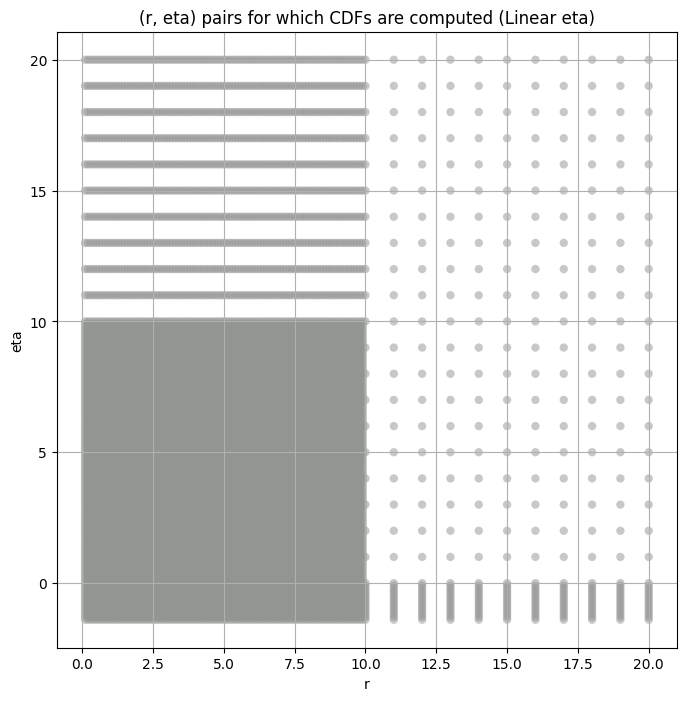

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [8]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [9]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [10]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 11


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 14


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 18


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 21


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 24


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 27


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 31


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
band                                                                    
2     5.139321e+07  4.463775e+07  6.096572e+07  34.034298   15.248034   
5     2.524177e+09  2.353391e+09  2.699740e+09   5.179779    4.626152   
8     1.757398e+09  1.641078e+09  1.877120e+09   4.847562    4.286242   
11    1.457189e+09  1.371756e+09  1.544339e+09   3.334230    2.998650   
14    4.547888e+08  4.189689e+08  4.917462e+08   7.730319    6.900269   
18    7.997943e+07  7.346398e+07  8.697122e+07   8.767644    6.914291   
21    2.985251e+07  2.706179e+07  3.292391e+07  12.333047    8.880222   
24    1.525364e+07  1.320449e+07  1.753561e+07  28.565693   21.727388   
27    1.007582e+07  8.521706e+06  1.176972e+07  37.237705   31.112600   
31    2.894142e+05  2.358549e+05  3.573860e+05  63.037277   39.385593   

      kurt_upper  total_samples  
band                             
2     117.524994     58064760.0  
5       5.774006     58064760.0  
8       5.420815     58064760.0  
11      3.684760     58064760.0  
14      8.605524     58064760.0  
18     11.307163     58064760.0  
21     17.917091     58064760.0  
24     36.901050     58064760.0  
27     44.299973     58064760.0  
31    147.871980     58064760.0

## Initial Grid Search and Hypothesis Test Plots

In [11]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [12]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
band                                                                
2     5.139321e+07   5.139321e+07    4.750463e+07    4.564042e+07   
5     2.524177e+09   2.524177e+09    2.486232e+09    2.453681e+09   
8     1.757398e+09   1.757398e+09    1.731390e+09    1.708124e+09   
11    1.457189e+09   1.457189e+09    1.442001e+09    1.428191e+09   
14    4.547888e+08   4.547888e+08    4.460381e+08    4.384568e+08   
18    7.997943e+07   7.997943e+07    7.748746e+07    7.573524e+07   
21    2.985251e+07   2.985251e+07    2.858114e+07    2.777317e+07   
24    1.525364e+07   1.525364e+07    1.426186e+07    1.357560e+07   
27    1.007582e+07   1.007582e+07    9.435878e+06    8.941874e+06   
31    2.894142e+05   2.894142e+05    2.593659e+05    2.418378e+05   

      var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
band                                                                      
2       4.415148e+07     4.287236e+07     4.071572e+07     3.891237e+07   
5       2.423913e+09     2.396057e+09     2.344472e+09     2.297070e+09   
8       1.686474e+09     1.666088e+09     1.628386e+09     1.593988e+09   
11      1.415159e+09     1.402715e+09     1.379232e+09     1.357251e+09   
14      4.315064e+08     4.250160e+08     4.130870e+08     4.022233e+08   
18      7.425014e+07     7.293582e+07     7.064741e+07     6.866976e+07   
21      2.711262e+07     2.654253e+07     2.557976e+07     2.477591e+07   
24      1.301356e+07     1.253107e+07     1.172442e+07     1.106117e+07   
27      8.517147e+06     8.140467e+06     7.489734e+06     6.938666e+06   
31      2.275341e+05     2.152365e+05     1.948456e+05     1.783823e+05   

      var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
band                                                                      
2        3.734754e+07     3.595810e+07     3.470730e+07     3.156440e+07  
5        2.252930e+09     2.211405e+09     2.172045e+09     2.064422e+09  
8        1.562166e+09     1.532495e+09     1.504669e+09     1.429998e+09  
11       1.336483e+09     1.316734e+09     1.297857e+09     1.245495e+09  
14       3.921855e+08     3.828196e+08     3.740177e+08     3.503199e+08  
18       6.691071e+07     6.531757e+07     6.385621e+07     6.005993e+07  
21       2.408022e+07     2.346349e+07     2.290567e+07     2.146327e+07  
24       1.049656e+07     1.000522e+07     9.570695e+06     8.510564e+06  
27       6.461040e+06     6.040110e+06     5.665224e+06     4.746618e+06  
31       1.646130e+05     1.528378e+05     1.426051e+05     1.184409e+05

####
Band  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.003867978446245035 51393212.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.003707411922561965 47504630.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.003481771420136129 45640416.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.004038936320345132 44151476.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.0034840983565094345 42872364.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.004396705626909858 40715724.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.005147211370547539 38912372.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.006030539642855437 37347536.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.006690440733053693 35958096.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.007560312663237534 34707304.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.009911762527896543 31564402.0
Number of samples: 100000, Without approximation : 58064760.0


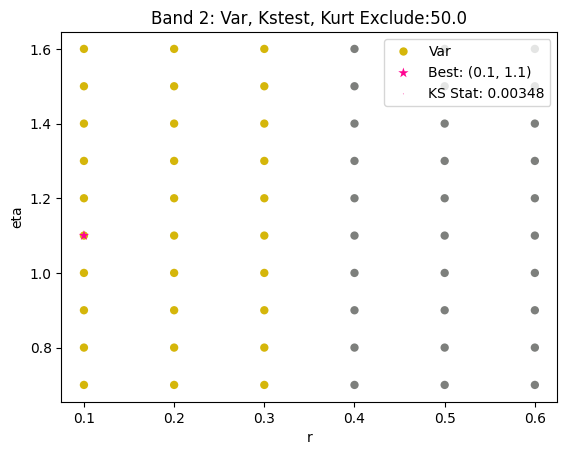

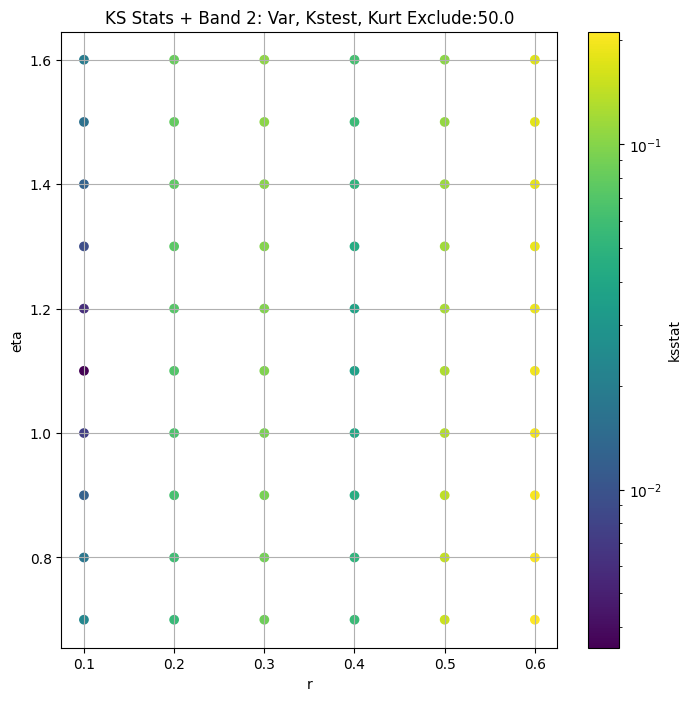

####
Band  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.04278136558793788 2524177400.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.04349072588400116 2486231600.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.04370505005379599 2453681400.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.043252350294773034 2423913000.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.04282425891636232 2396057000.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.043539790755744975 2344471600.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.04449569335674776 2297070300.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.04540321521828322 2252930300.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.044865641881144724 2211404800.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.04469787707374384 2172045300.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.04694361108734452 2064422000.0
Number of samples: 100000, Without approximation : 58064760.0


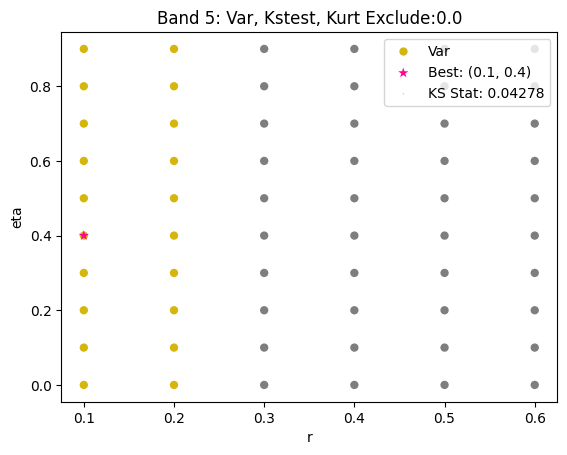

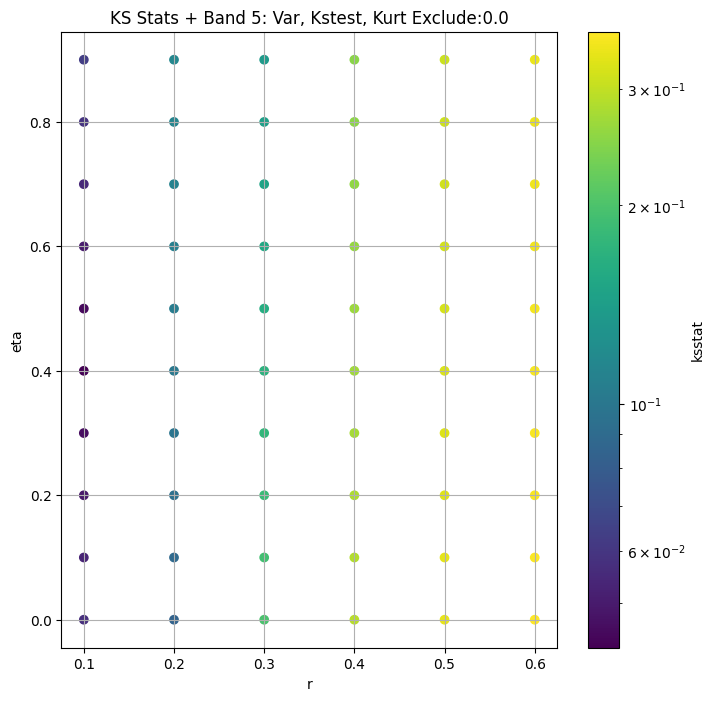

####
Band  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.022377412332590607 1757397600.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.023326304171312845 1731390100.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.024253145847425744 1708123800.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.024799101275766233 1686474500.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.0244085068504446 1666087800.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.024374301267756082 1628386300.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.025836005966317965 1593987800.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.025734230803456937 1562166100.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.02579174598019121 1532494800.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.02704459777985345 1504668800.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.028124485433603907 1429997600.0
Number of samples: 100000, Without approximation : 58064760.0


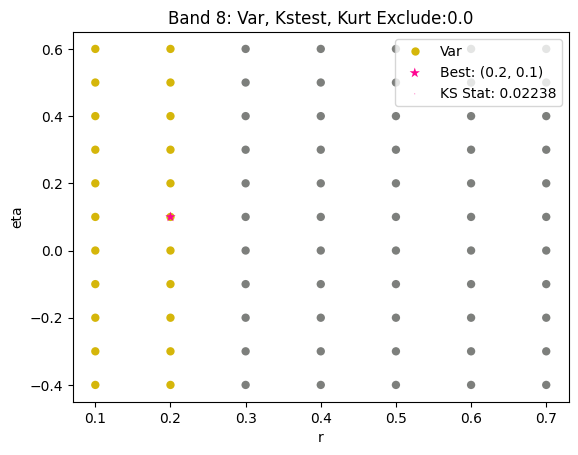

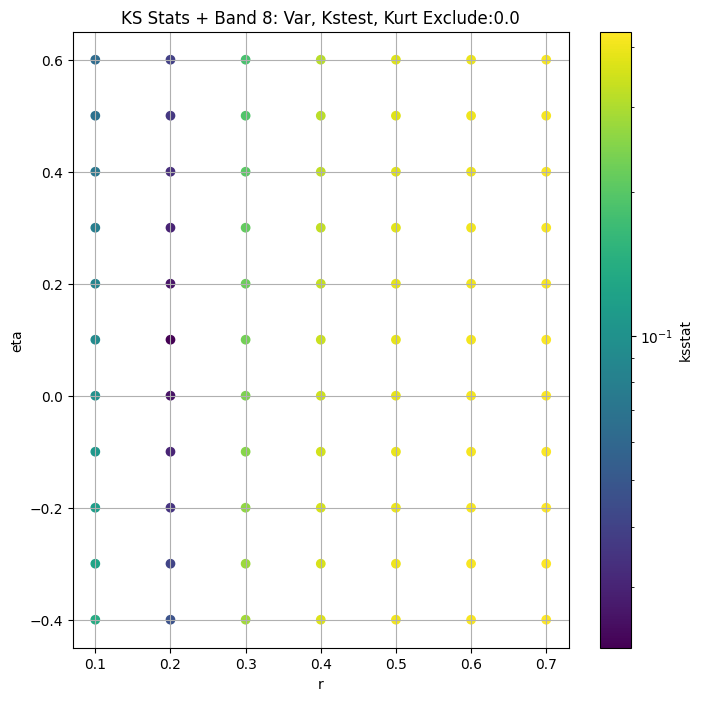

####
Band  11


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 0 0.026232051341117682 1457189100.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 25 0.025925303148698453 1442000900.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 50 0.025532904121290056 1428191400.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 75 0.025607728010375252 1415158800.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 100 0.026156328561338052 1402715300.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 150 0.02720836096794886 1379231600.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 200 0.027550148813581254 1357251500.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 250 0.02705024650159546 1336482700.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 300 0.027968372972497837 1316734100.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 350 0.028862631977459863 1297857400.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 500 0.029567834727446285 1245495000.0
Number of samples: 100000, Without approximation : 58064760.0


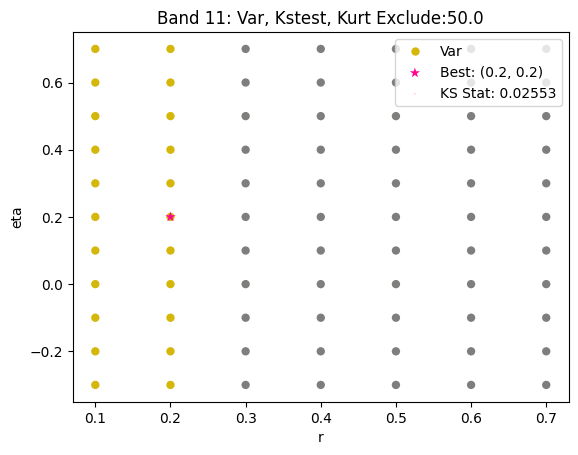

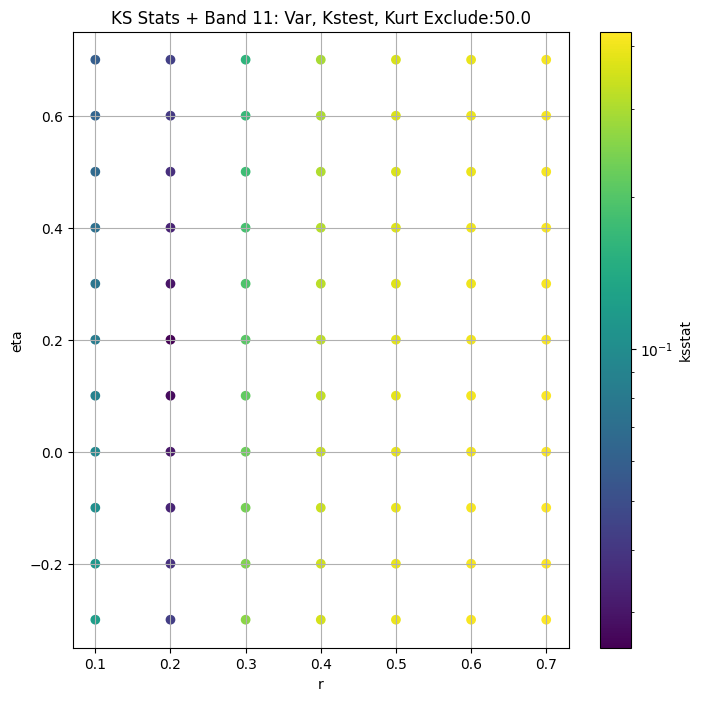

####
Band  14


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 0 0.019018937943772518 454788770.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 25 0.019109279061539253 446038100.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 50 0.018395052454396765 438456770.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 75 0.017736511375111563 431506370.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 100 0.017752299923063375 425015970.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 150 0.019305462648970456 413086980.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 200 0.02077554680426985 402223300.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 250 0.02216984212563522 392185500.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 300 0.02123617675861711 382819620.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 350 0.020754497105465508 374017700.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 500 0.024321466682678428 350319870.0
Number of samples: 100000, Without approximation : 58064760.0


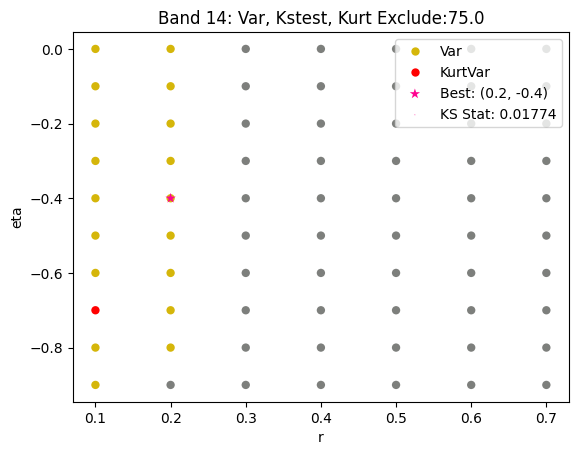

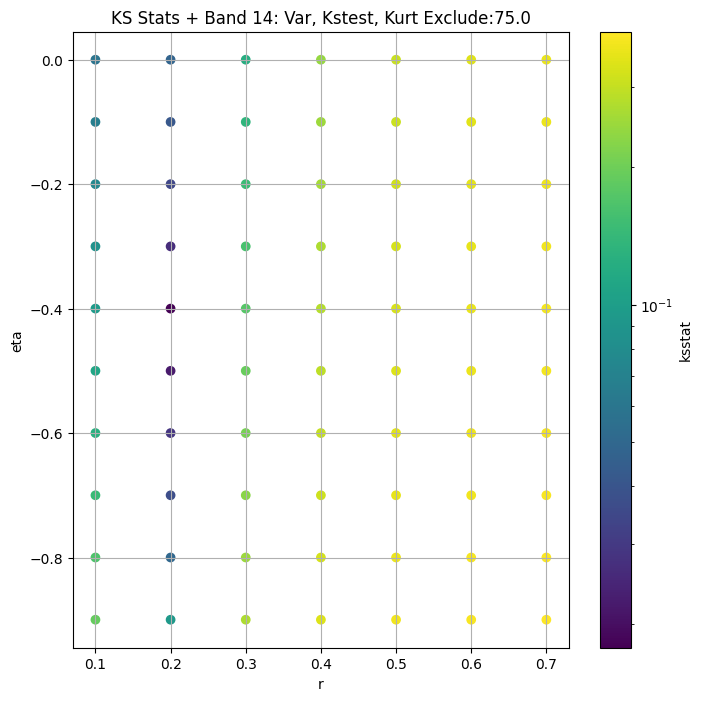

####
Band  18


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 0 0.016546149683289033 79979430.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 25 0.017965477226136506 77487464.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 50 0.01717711394266741 75735240.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 75 0.017776393862477535 74250140.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 100 0.018766900549471055 72935816.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 150 0.01981822828008395 70647410.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 200 0.019666048338873657 68669760.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 250 0.021092584863064895 66910708.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 300 0.021620189304016102 65317572.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 350 0.02160252690901643 63856210.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 500 0.023193996146035456 60059930.0
Number of samples: 100000, Without approximation : 58064760.0


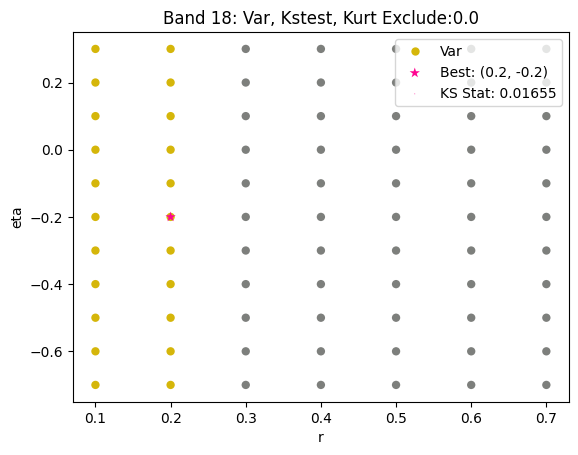

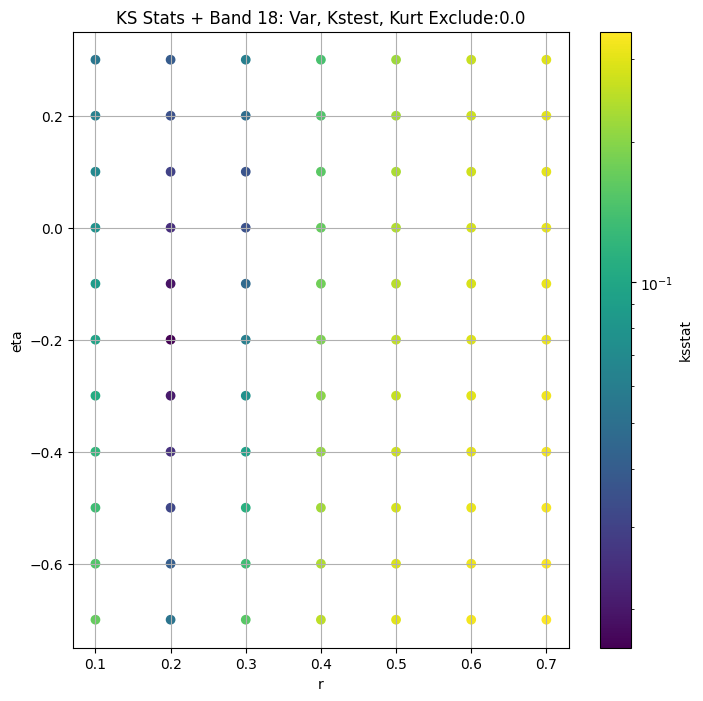

####
Band  21


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 0 0.01617268530119742 29852508.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 25 0.014891149217391375 28581142.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 50 0.01629169926850789 27773172.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 75 0.017488402663331695 27112616.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 100 0.018551910027368668 26542532.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 150 0.018301910792061005 25579760.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 200 0.01879959205179449 24775908.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 250 0.020189065616211352 24080218.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 300 0.021477591003366367 23463492.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 350 0.02106918977011929 22905670.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 500 0.023259772022316105 21463272.0
Number of samples: 100000, Without approximation : 58064760.0


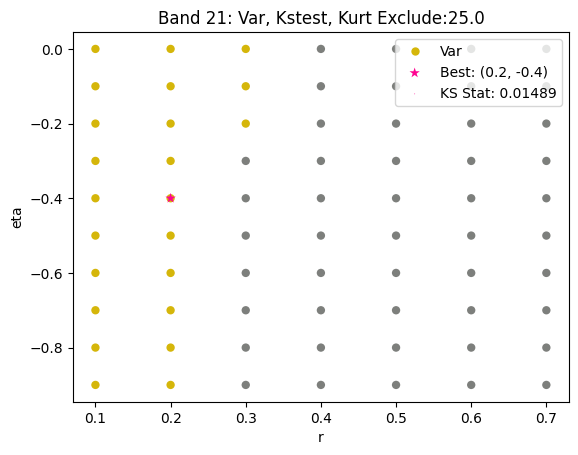

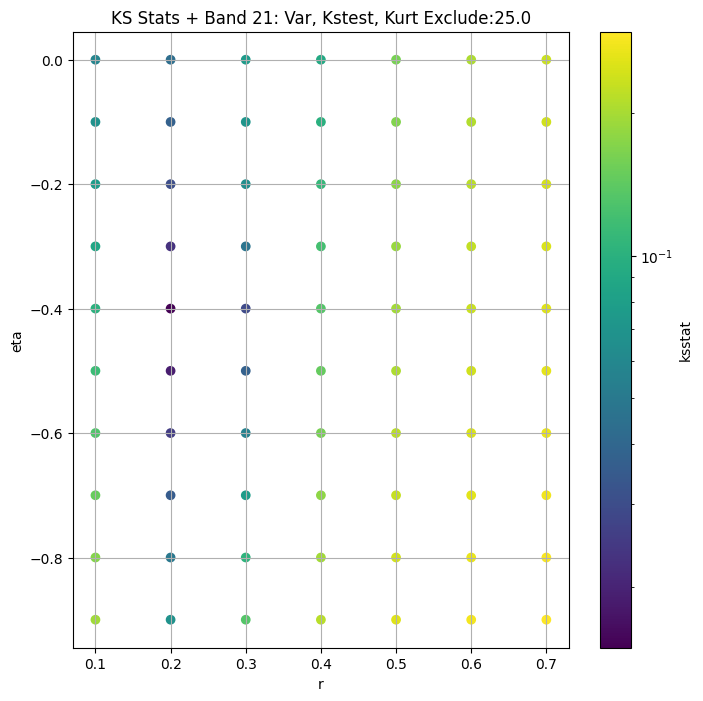

####
Band  24


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 0 0.007225690885941577 15253643.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 25 0.00980082055358733 14261860.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 50 0.01196292775478805 13575599.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 75 0.01392489418590108 13013558.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 100 0.015693020454412343 12531066.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 150 0.012834192343036399 11724423.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 200 0.013361046438661948 11061167.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 250 0.015303139233344296 10496557.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 300 0.017193893874999713 10005216.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 350 0.019031149962591448 9570695.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 500 0.01879734536165066 8510564.0
Number of samples: 100000, Without approximation : 58064760.0


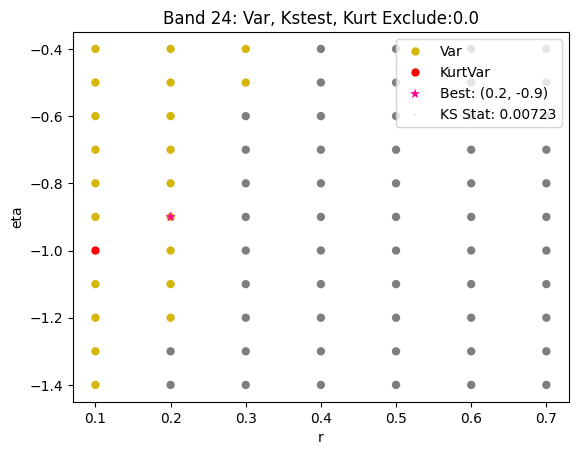

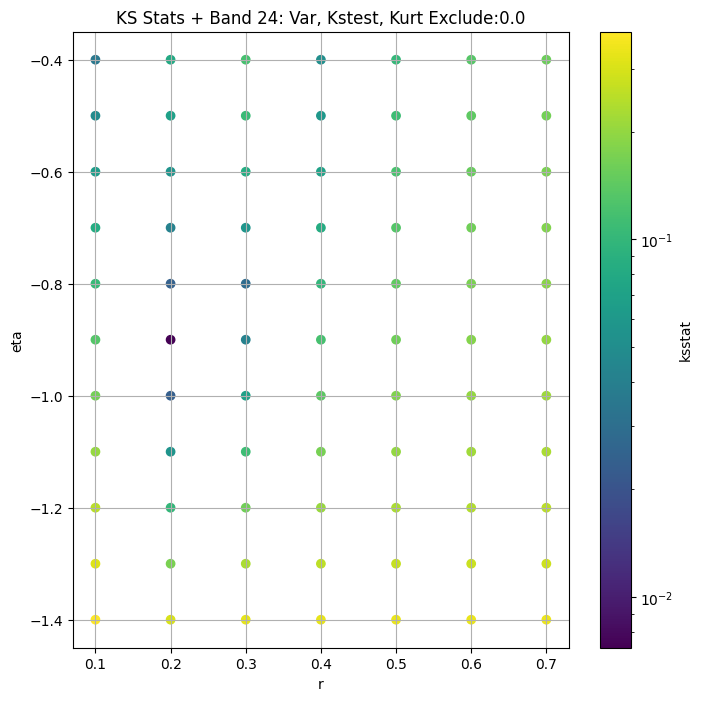

####
Band  27


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 0 0.011542630038935076 10075819.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 25 0.011366749460999581 9435878.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 50 0.01124211103654335 8941874.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 75 0.01351867730331835 8517147.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 100 0.0133066723668539 8140467.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 150 0.012952555736136961 7489733.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 200 0.012655363151417354 6938666.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 250 0.012397772498425774 6461039.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 300 0.010193837447400322 6040110.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 350 0.010079625489506139 5665223.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 500 0.011276702535331154 4746618.5
Number of samples: 100000, Without approximation : 58064760.0


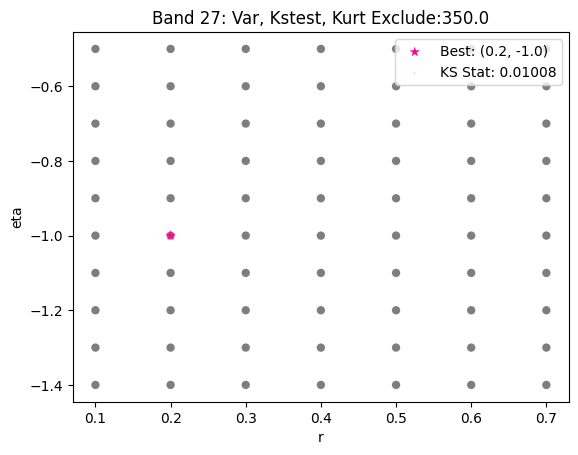

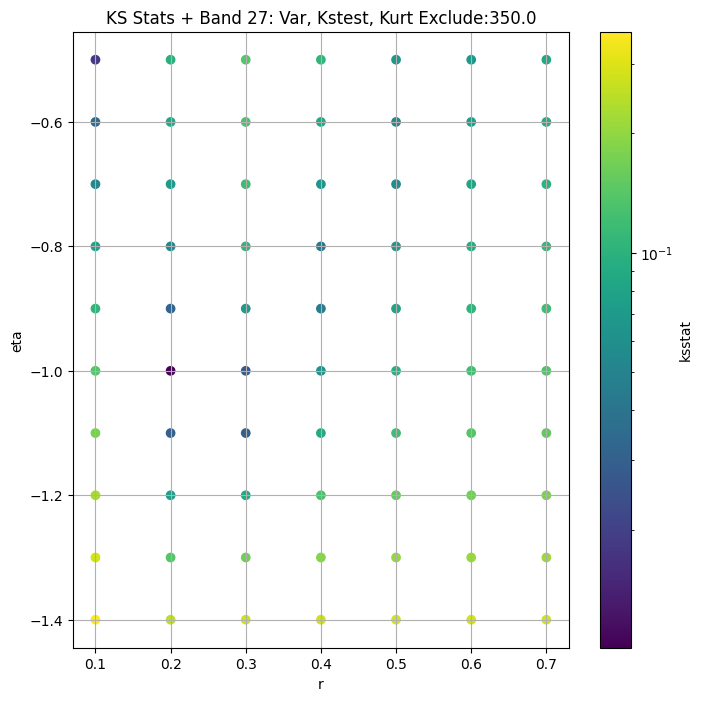

####
Band  31


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 0 0.031135328371872162 289414.16


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 25 0.030969683920585855 259365.94


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 50 0.030868210384726535 241837.84


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 75 0.03078388458431558 227534.14


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 100 0.030707361988511317 215236.52


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 150 0.030573491371007955 194845.6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 200 0.030502279895861684 178382.28


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 250 0.030831751867795854 164612.98


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 300 0.030730326642153305 152837.77


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 350 0.03063954380926137 142605.1


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 500 0.030406247362755878 118440.87
Number of samples: 100000, Without approximation : 58064760.0


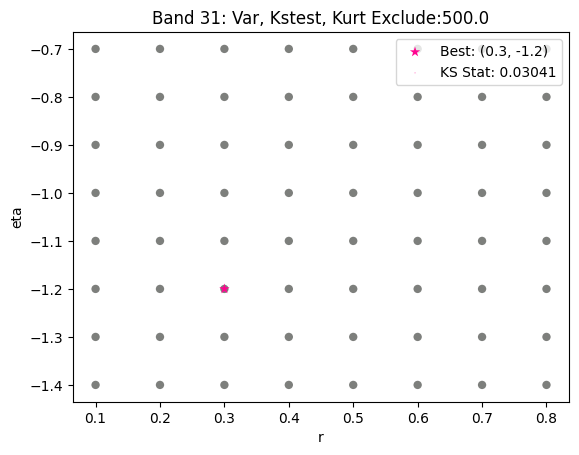

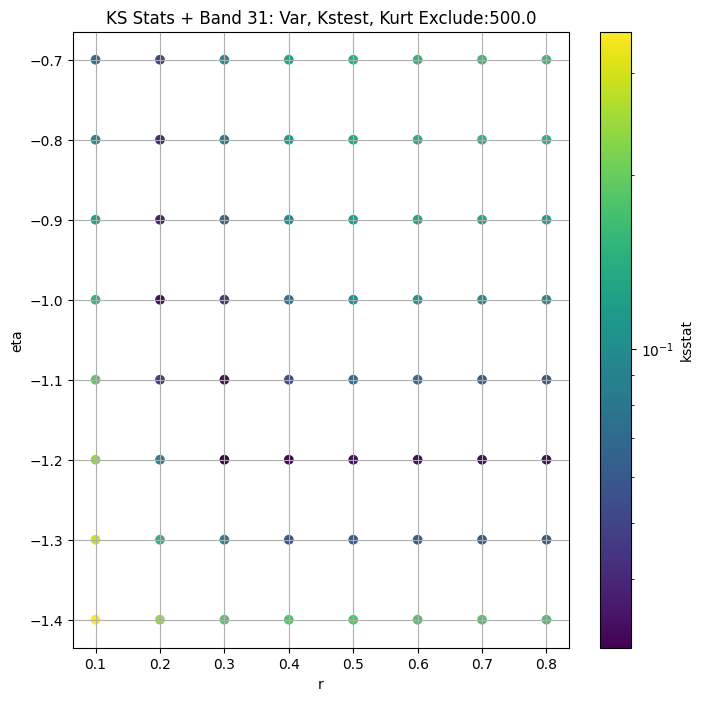

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
band                                                                    
2     5.139321e+07  4.463775e+07  6.096572e+07  34.034298   15.248034   
5     2.524177e+09  2.353391e+09  2.699740e+09   5.179779    4.626152   
8     1.757398e+09  1.641078e+09  1.877120e+09   4.847562    4.286242   
11    1.457189e+09  1.371756e+09  1.544339e+09   3.334230    2.998650   
14    4.547888e+08  4.189689e+08  4.917462e+08   7.730319    6.900269   
18    7.997943e+07  7.346398e+07  8.697122e+07   8.767644    6.914291   
21    2.985251e+07  2.706179e+07  3.292391e+07  12.333047    8.880222   
24    1.525364e+07  1.320449e+07  1.753561e+07  28.565693   21.727388   
27    1.007582e+07  8.521706e+06  1.176972e+07  37.237705   31.112600   
31    2.894142e+05  2.358549e+05  3.573860e+05  63.037277   39.385593   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2     117.524994     58064760.0             0.003482        0.1          1.1   
5       5.774006     58064760.0             0.042781        0.1          0.4   
8       5.420815     58064760.0             0.022377        0.2          0.1   
11      3.684760     58064760.0             0.025533        0.2          0.2   
14      8.605524     58064760.0             0.017737        0.2         -0.4   
18     11.307163     58064760.0             0.016546        0.2         -0.2   
21     17.917091     58064760.0             0.014891        0.2         -0.4   
24     36.901050     58064760.0             0.007226        0.2         -0.9   
27     44.299973     58064760.0             0.010080        0.2         -1.0   
31    147.871980     58064760.0             0.030406        0.3         -1.2   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      6.851137e-08                    50.0        4.564042e+07   
5      5.300539e-05                     0.0        2.524177e+09   
8      1.849114e+04                     0.0        1.757398e+09   
11     1.171782e+04                    50.0        1.428191e+09   
14     1.993000e+04                    75.0        4.315064e+08   
18     1.934959e+03                     0.0        7.997943e+07   
21     1.320078e+03                    25.0        2.858114e+07   
24     6.053033e+03                     0.0        1.525364e+07   
27     4.024579e+03                   350.0        5.665224e+06   
31     1.278986e+04                   500.0        1.184409e+05   

      kstest_stat_cutoff_0.05  
band                           
2                    0.000178  
5                    0.000178  
8                    0.000178  
11                   0.000178  
14                   0.000178  
18                   0.000178  
21                   0.000178  
24                   0.000178  
27                   0.000178  
31                   0.000178

In [13]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [14]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Band 2


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 2, 50.0 + 100 = 150, ksstat: 0.005302306241249621, var: 40715724.0


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 2, 50.0 + 75 = 125, ksstat: 0.004925385678425709, var: 41738948.0


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 2, 50.0 + 50 = 100, ksstat: 0.004369895541627922, var: 42872364.0


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 2, 50.0 + 25 = 75, ksstat: 0.00373351672972003, var: 44151476.0


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 2, 50.0 + 0 = 50, ksstat: 0.003481771420136129, var: 45640416.0


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 2, 50.0 + -25 = 25, ksstat: 0.0027422320322505467, var: 47504632.0


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 2, 50.0 + -50 = 0, ksstat: 0.001927953018703632, var: 51393212.0
Number of samples: 100000, Without approximation : 58064760.0


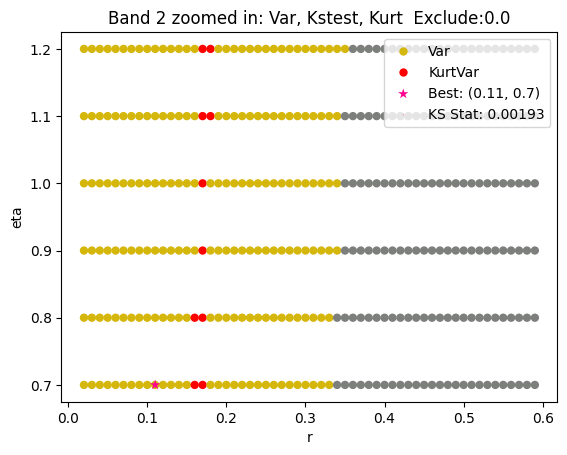

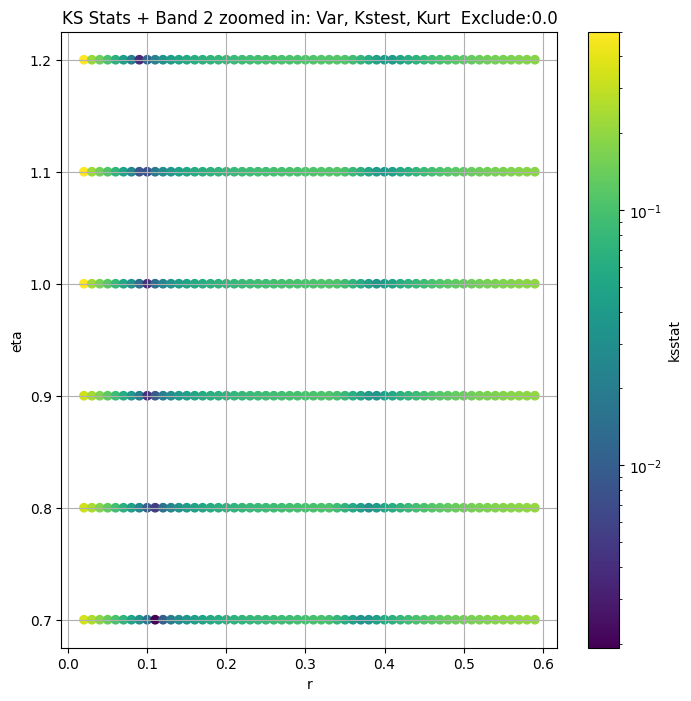

Band 5


  0%|          | 0/567 [00:00<?, ?it/s]

Finding Minimum after computing 567 CDFs
band 5, 0.0 + 100 = 100, ksstat: 0.041529118712595015, var: 2396057088.0


  0%|          | 0/567 [00:00<?, ?it/s]

Finding Minimum after computing 567 CDFs
band 5, 0.0 + 75 = 75, ksstat: 0.0419079287599341, var: 2423912960.0


  0%|          | 0/567 [00:00<?, ?it/s]

Finding Minimum after computing 567 CDFs
band 5, 0.0 + 50 = 50, ksstat: 0.0413352747230058, var: 2453681408.0


  0%|          | 0/567 [00:00<?, ?it/s]

Finding Minimum after computing 567 CDFs
band 5, 0.0 + 25 = 25, ksstat: 0.040877026404482764, var: 2486231552.0


  0%|          | 0/567 [00:00<?, ?it/s]

Finding Minimum after computing 567 CDFs
band 5, 0.0 + 0 = 0, ksstat: 0.04143902935162913, var: 2524177408.0
Number of samples: 100000, Without approximation : 58064760.0


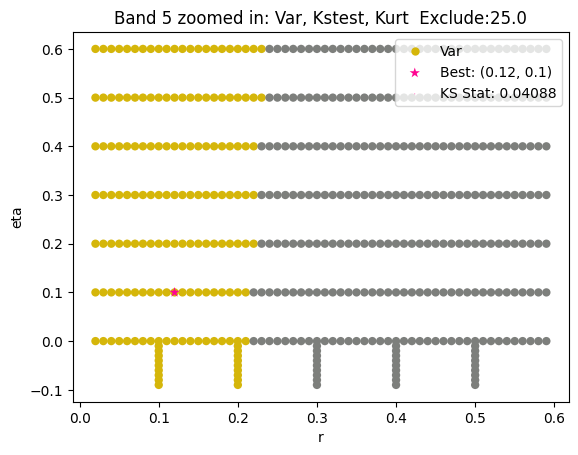

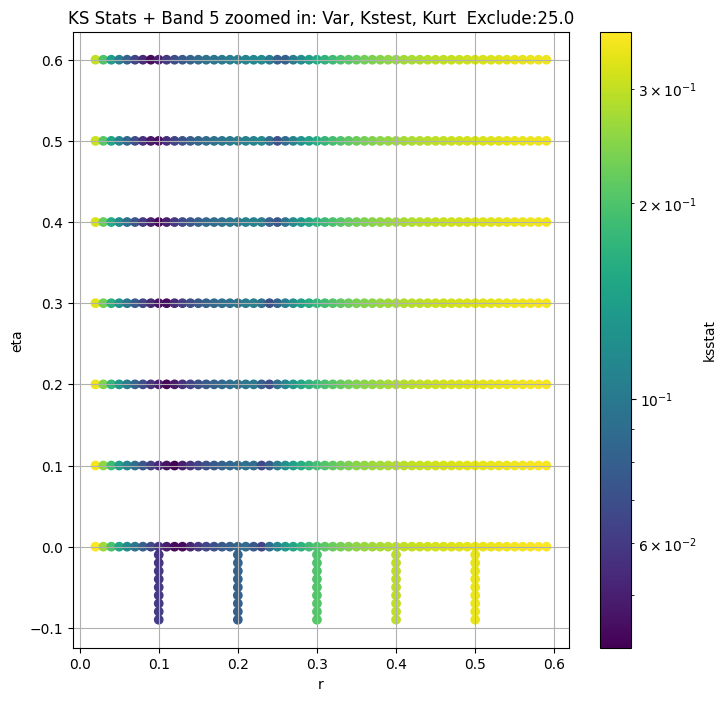

Band 8


  0%|          | 0/873 [00:00<?, ?it/s]

Finding Minimum after computing 873 CDFs
band 8, 0.0 + 100 = 100, ksstat: 0.02335491052118477, var: 1666087808.0


  0%|          | 0/873 [00:00<?, ?it/s]

Finding Minimum after computing 873 CDFs
band 8, 0.0 + 75 = 75, ksstat: 0.023101751303128984, var: 1686474496.0


  0%|          | 0/873 [00:00<?, ?it/s]

Finding Minimum after computing 873 CDFs
band 8, 0.0 + 50 = 50, ksstat: 0.023101751303128984, var: 1708123776.0


  0%|          | 0/873 [00:00<?, ?it/s]

Finding Minimum after computing 873 CDFs
band 8, 0.0 + 25 = 25, ksstat: 0.023101751303128984, var: 1731390080.0


  0%|          | 0/873 [00:00<?, ?it/s]

Finding Minimum after computing 873 CDFs
band 8, 0.0 + 0 = 0, ksstat: 0.022377412332590607, var: 1757397632.0
Number of samples: 100000, Without approximation : 58064760.0


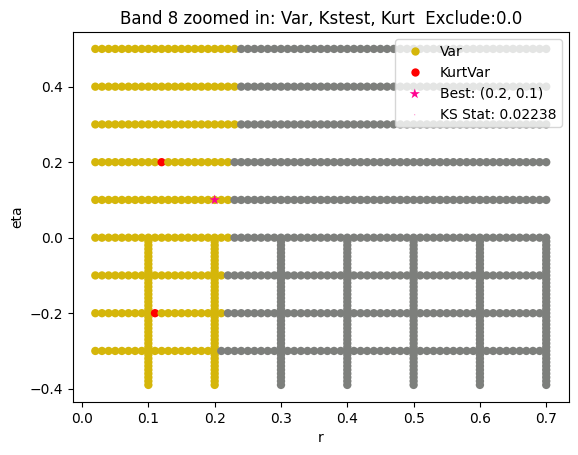

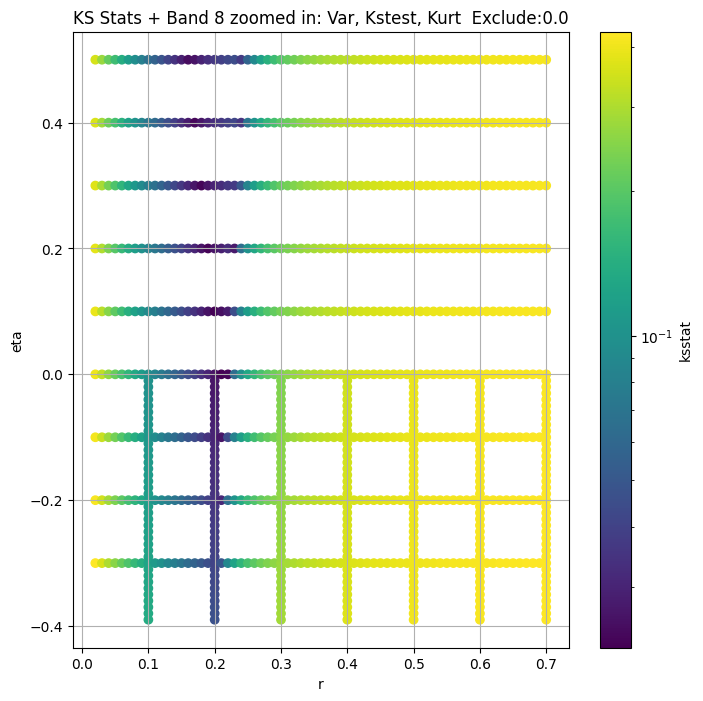

Band 11


  0%|          | 0/879 [00:00<?, ?it/s]

Finding Minimum after computing 879 CDFs
band 11, 50.0 + 100 = 150, ksstat: 0.026536090141694446, var: 1379231616.0


  0%|          | 0/879 [00:00<?, ?it/s]

Finding Minimum after computing 879 CDFs
band 11, 50.0 + 75 = 125, ksstat: 0.026690032554282095, var: 1390762240.0


  0%|          | 0/879 [00:00<?, ?it/s]

Finding Minimum after computing 879 CDFs
band 11, 50.0 + 50 = 100, ksstat: 0.026156328561338052, var: 1402715264.0


  0%|          | 0/879 [00:00<?, ?it/s]

Finding Minimum after computing 879 CDFs
band 11, 50.0 + 25 = 75, ksstat: 0.025607728010375252, var: 1415158784.0


  0%|          | 0/879 [00:00<?, ?it/s]

Finding Minimum after computing 879 CDFs
band 11, 50.0 + 0 = 50, ksstat: 0.025065716805091773, var: 1428191360.0


  0%|          | 0/879 [00:00<?, ?it/s]

Finding Minimum after computing 879 CDFs
band 11, 50.0 + -25 = 25, ksstat: 0.024743834198383552, var: 1442000896.0


  0%|          | 0/879 [00:00<?, ?it/s]

Finding Minimum after computing 879 CDFs
band 11, 50.0 + -50 = 0, ksstat: 0.02409164802348418, var: 1457189120.0
Number of samples: 100000, Without approximation : 58064760.0


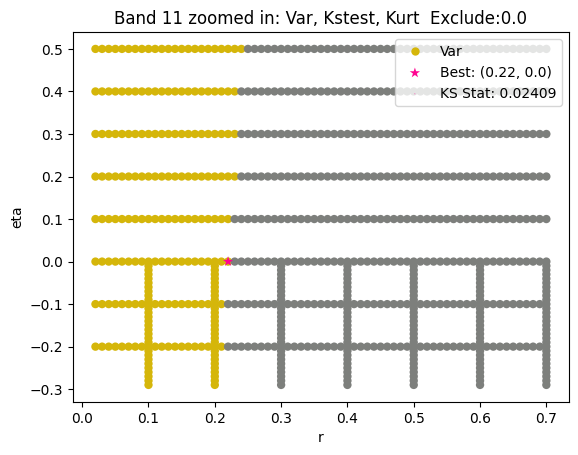

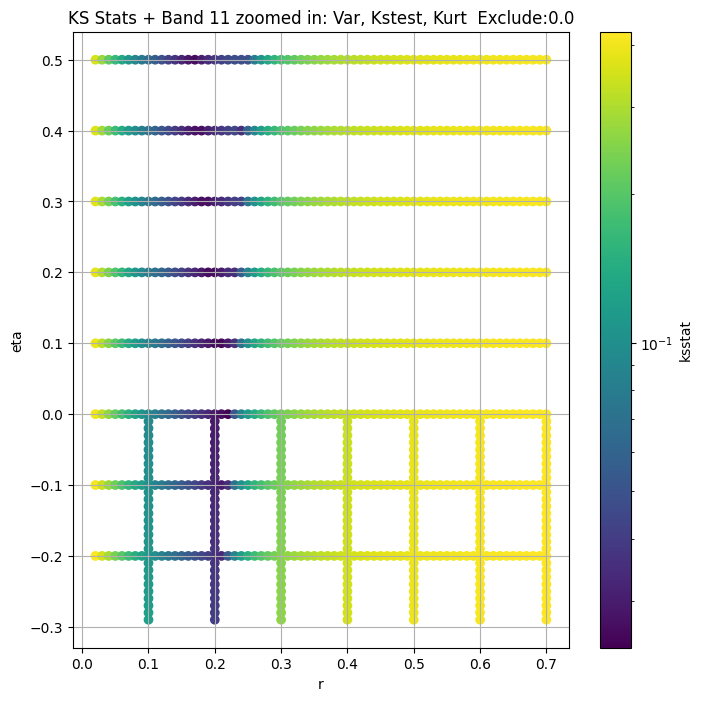

Band 14


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
band 14, 75.0 + 100 = 175, ksstat: 0.01876858505560286, var: 407540896.0


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
band 14, 75.0 + 75 = 150, ksstat: 0.018447844755949835, var: 413086976.0


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
band 14, 75.0 + 50 = 125, ksstat: 0.01811066186008657, var: 418896224.0


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
band 14, 75.0 + 25 = 100, ksstat: 0.017752299923063375, var: 425015968.0


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
band 14, 75.0 + 0 = 75, ksstat: 0.017366974520682615, var: 431506368.0


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
band 14, 75.0 + -25 = 50, ksstat: 0.0169461213145541, var: 438456768.0


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
band 14, 75.0 + -50 = 25, ksstat: 0.016471444182489012, var: 446038112.0


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
band 14, 75.0 + -75 = 0, ksstat: 0.01564150042849123, var: 454788768.0
Number of samples: 100000, Without approximation : 58064760.0


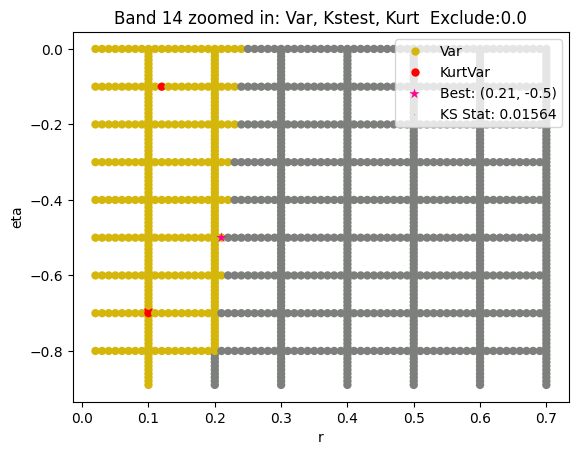

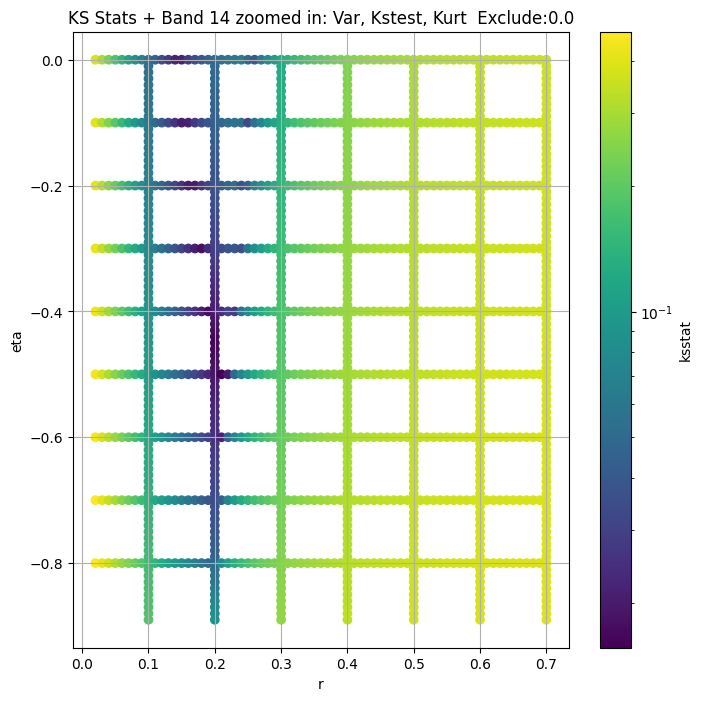

Band 18


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 18, 0.0 + 100 = 100, ksstat: 0.01662900092251518, var: 72935816.0


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 18, 0.0 + 75 = 75, ksstat: 0.016155153763110247, var: 74250144.0


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 18, 0.0 + 50 = 50, ksstat: 0.01518268615992524, var: 75735240.0


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 18, 0.0 + 25 = 25, ksstat: 0.01568261297496011, var: 77487464.0


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 18, 0.0 + 0 = 0, ksstat: 0.014101503035654717, var: 79979432.0
Number of samples: 100000, Without approximation : 58064760.0


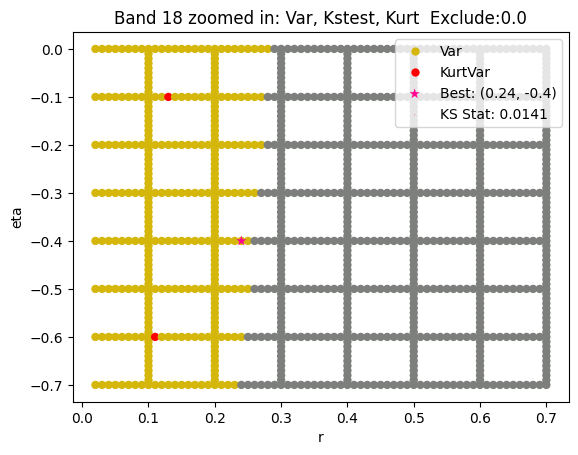

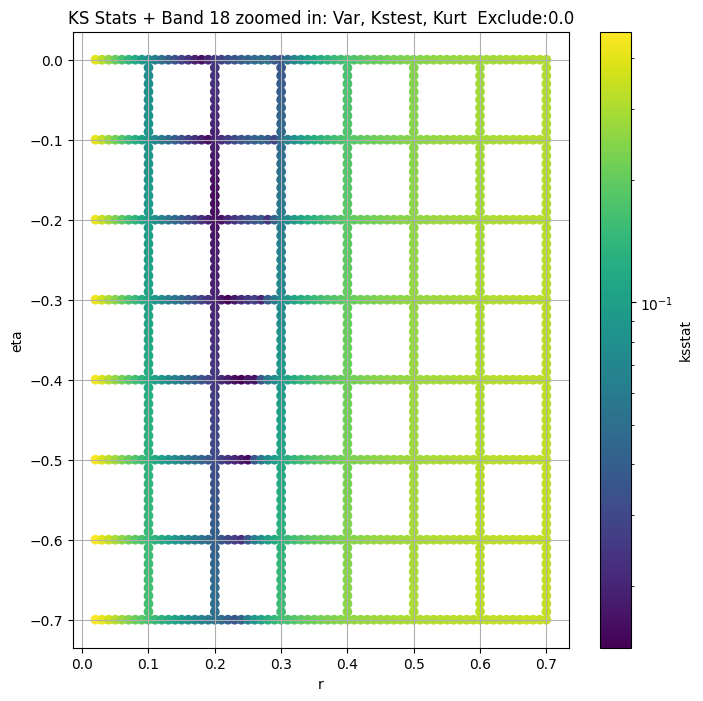

Band 21


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
band 21, 25.0 + 100 = 125, ksstat: 0.015983294101122203, var: 26036638.0


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
band 21, 25.0 + 75 = 100, ksstat: 0.015105832446882295, var: 26542532.0


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
band 21, 25.0 + 50 = 75, ksstat: 0.01409706531344529, var: 27112616.0


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
band 21, 25.0 + 25 = 50, ksstat: 0.014735923892132838, var: 27773172.0


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
band 21, 25.0 + 0 = 25, ksstat: 0.013349254307553474, var: 28581142.0


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
band 21, 25.0 + -25 = 0, ksstat: 0.01292442894293816, var: 29852508.0
Number of samples: 100000, Without approximation : 58064760.0


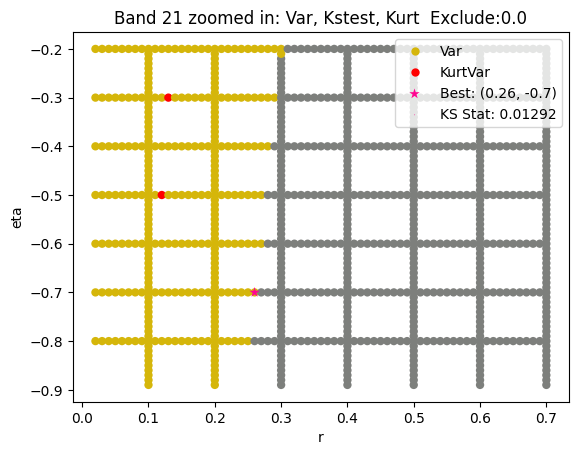

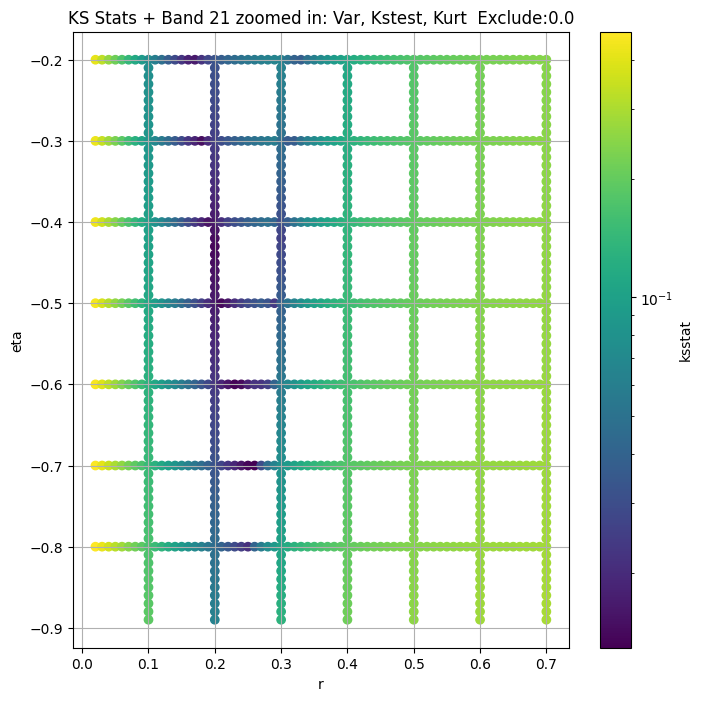

Band 24


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 24, 0.0 + 100 = 100, ksstat: 0.009388347524138446, var: 12531066.0


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 24, 0.0 + 75 = 75, ksstat: 0.00954389658360666, var: 13013558.0


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 24, 0.0 + 50 = 50, ksstat: 0.008184392571490368, var: 13575599.0


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 24, 0.0 + 25 = 25, ksstat: 0.006485041855896406, var: 14261860.0


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 24, 0.0 + 0 = 0, ksstat: 0.005044551568596345, var: 15253643.0
Number of samples: 100000, Without approximation : 58064760.0


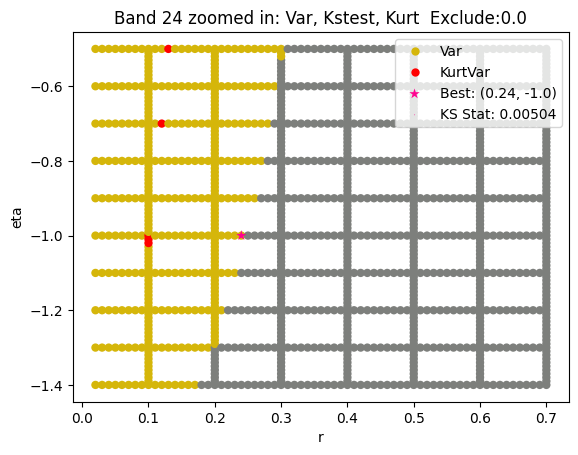

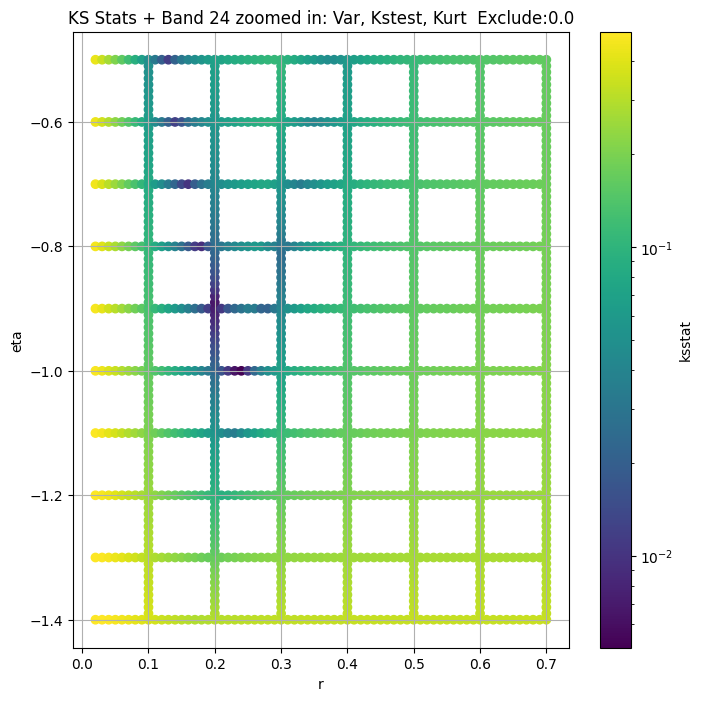

Band 27


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 27, 350.0 + 100 = 450, ksstat: 0.009472031682639732, var: 5023687.0


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 27, 350.0 + 75 = 425, ksstat: 0.009122361725713742, var: 5172291.5


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 27, 350.0 + 50 = 400, ksstat: 0.00900614738244021, var: 5328341.5


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 27, 350.0 + 25 = 375, ksstat: 0.008724274151723648, var: 5492427.0


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 27, 350.0 + 0 = 350, ksstat: 0.008435762512608691, var: 5665223.5


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 27, 350.0 + -25 = 325, ksstat: 0.00844092618420944, var: 5847450.5


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 27, 350.0 + -50 = 300, ksstat: 0.008229889276284985, var: 6040110.5


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 27, 350.0 + -75 = 275, ksstat: 0.008267581151344627, var: 6244280.5


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 27, 350.0 + -100 = 250, ksstat: 0.008307037331657718, var: 6461039.5
Number of samples: 100000, Without approximation : 58064760.0


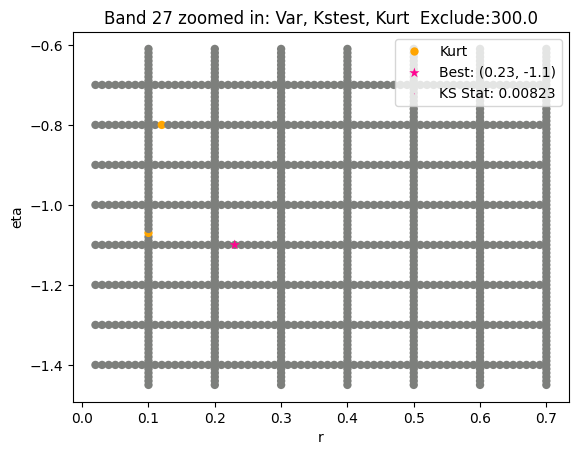

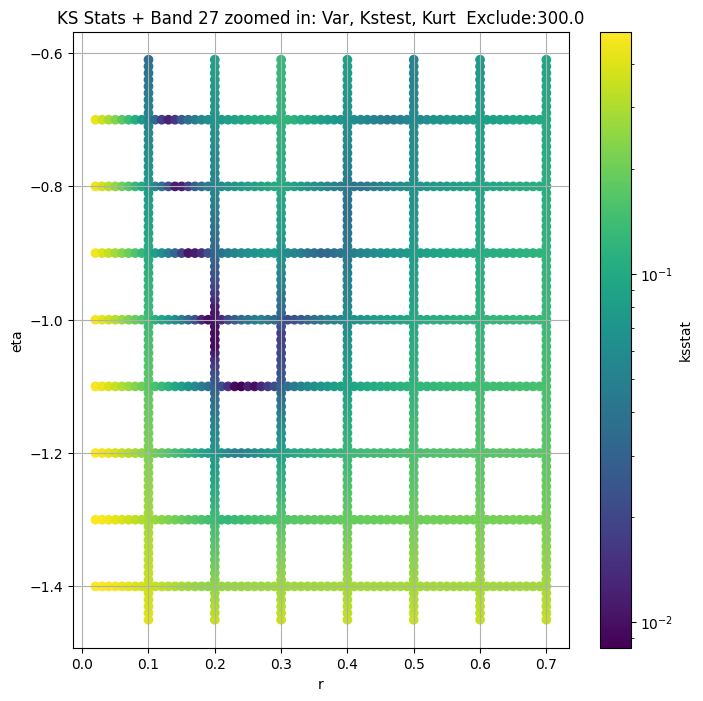

Band 31


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 500.0 + 100 = 600, ksstat: 0.027466998549440458, var: 106114.125


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 500.0 + 75 = 575, ksstat: 0.027195141897434327, var: 108975.875


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 500.0 + 50 = 550, ksstat: 0.027220905265714745, var: 111977.0234375


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 500.0 + 25 = 525, ksstat: 0.02724689676857367, var: 115128.3359375


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 500.0 + 0 = 500, ksstat: 0.027273122660724902, var: 118440.8671875


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 500.0 + -25 = 475, ksstat: 0.027302168593373644, var: 121928.078125


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 500.0 + -50 = 450, ksstat: 0.027332381095198532, var: 125606.28125


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 500.0 + -75 = 425, ksstat: 0.027101732234457165, var: 129491.7890625


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 500.0 + -100 = 400, ksstat: 0.026972161348111756, var: 133604.890625
Number of samples: 100000, Without approximation : 58064760.0


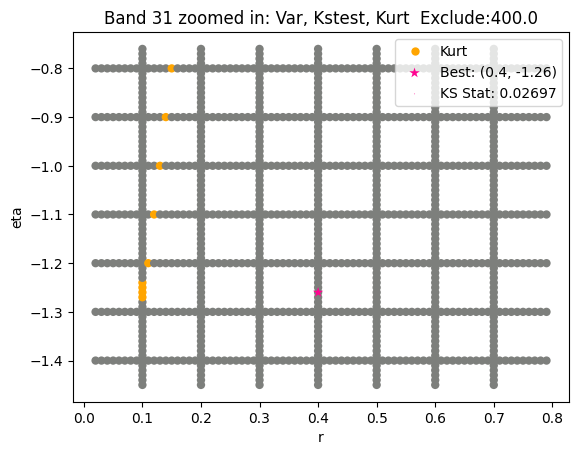

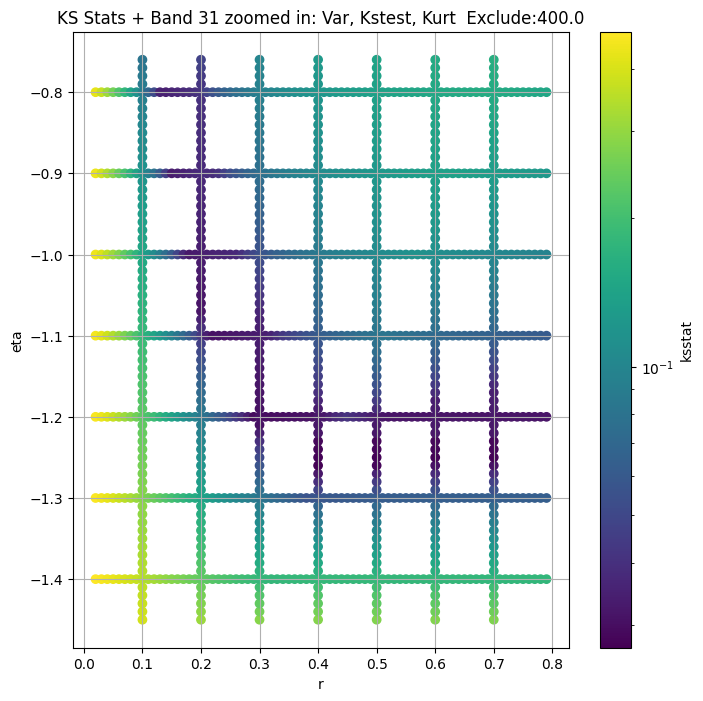

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
band                                                                    
2     5.139321e+07  4.463775e+07  6.096572e+07  34.034298   15.248034   
5     2.524177e+09  2.353391e+09  2.699740e+09   5.179779    4.626152   
8     1.757398e+09  1.641078e+09  1.877120e+09   4.847562    4.286242   
11    1.457189e+09  1.371756e+09  1.544339e+09   3.334230    2.998650   
14    4.547888e+08  4.189689e+08  4.917462e+08   7.730319    6.900269   
18    7.997943e+07  7.346398e+07  8.697122e+07   8.767644    6.914291   
21    2.985251e+07  2.706179e+07  3.292391e+07  12.333047    8.880222   
24    1.525364e+07  1.320449e+07  1.753561e+07  28.565693   21.727388   
27    1.007582e+07  8.521706e+06  1.176972e+07  37.237705   31.112600   
31    2.894142e+05  2.358549e+05  3.573860e+05  63.037277   39.385593   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2     117.524994     58064760.0             0.003482        0.1          1.1   
5       5.774006     58064760.0             0.042781        0.1          0.4   
8       5.420815     58064760.0             0.022377        0.2          0.1   
11      3.684760     58064760.0             0.025533        0.2          0.2   
14      8.605524     58064760.0             0.017737        0.2         -0.4   
18     11.307163     58064760.0             0.016546        0.2         -0.2   
21     17.917091     58064760.0             0.014891        0.2         -0.4   
24     36.901050     58064760.0             0.007226        0.2         -0.9   
27     44.299973     58064760.0             0.010080        0.2         -1.0   
31    147.871980     58064760.0             0.030406        0.3         -1.2   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      6.851137e-08                    50.0        5.139321e+07   
5      5.300539e-05                     0.0        2.486232e+09   
8      1.849114e+04                     0.0        1.757398e+09   
11     1.171782e+04                    50.0        1.457189e+09   
14     1.993000e+04                    75.0        4.547888e+08   
18     1.934959e+03                     0.0        7.997943e+07   
21     1.320078e+03                    25.0        2.985251e+07   
24     6.053033e+03                     0.0        1.525364e+07   
27     4.024579e+03                   350.0        6.040110e+06   
31     1.278986e+04                   500.0        1.336049e+05   

      kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
band                                                                
2                    0.000178          0.001928    0.11      0.70   
5                    0.000178          0.040877    0.12      0.10   
8                    0.000178          0.022377    0.20      0.10   
11                   0.000178          0.024092    0.22      0.00   
14                   0.000178          0.015642    0.21     -0.50   
18                   0.000178          0.014102    0.24     -0.40   
21                   0.000178          0.012924    0.26     -0.70   
24                   0.000178          0.005045    0.24     -1.00   
27                   0.000178          0.008230    0.23     -1.10   
31                   0.000178          0.026972    0.40     -1.26   

         best_scale  best_exclude_cutoff  n_pval_0.05  
band                                                   
2          0.000015                  0.0       510333  
5          0.150714                 25.0         1117  
8      18491.136700                  0.0         3543  
11     87139.533300                  0.0         3189  
14     61052.663455                  0.0         7972  
18     44110.908381                  0.0         8968  
21    100000.000000                  0.0        10630  
24     85661.460399                

In [15]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

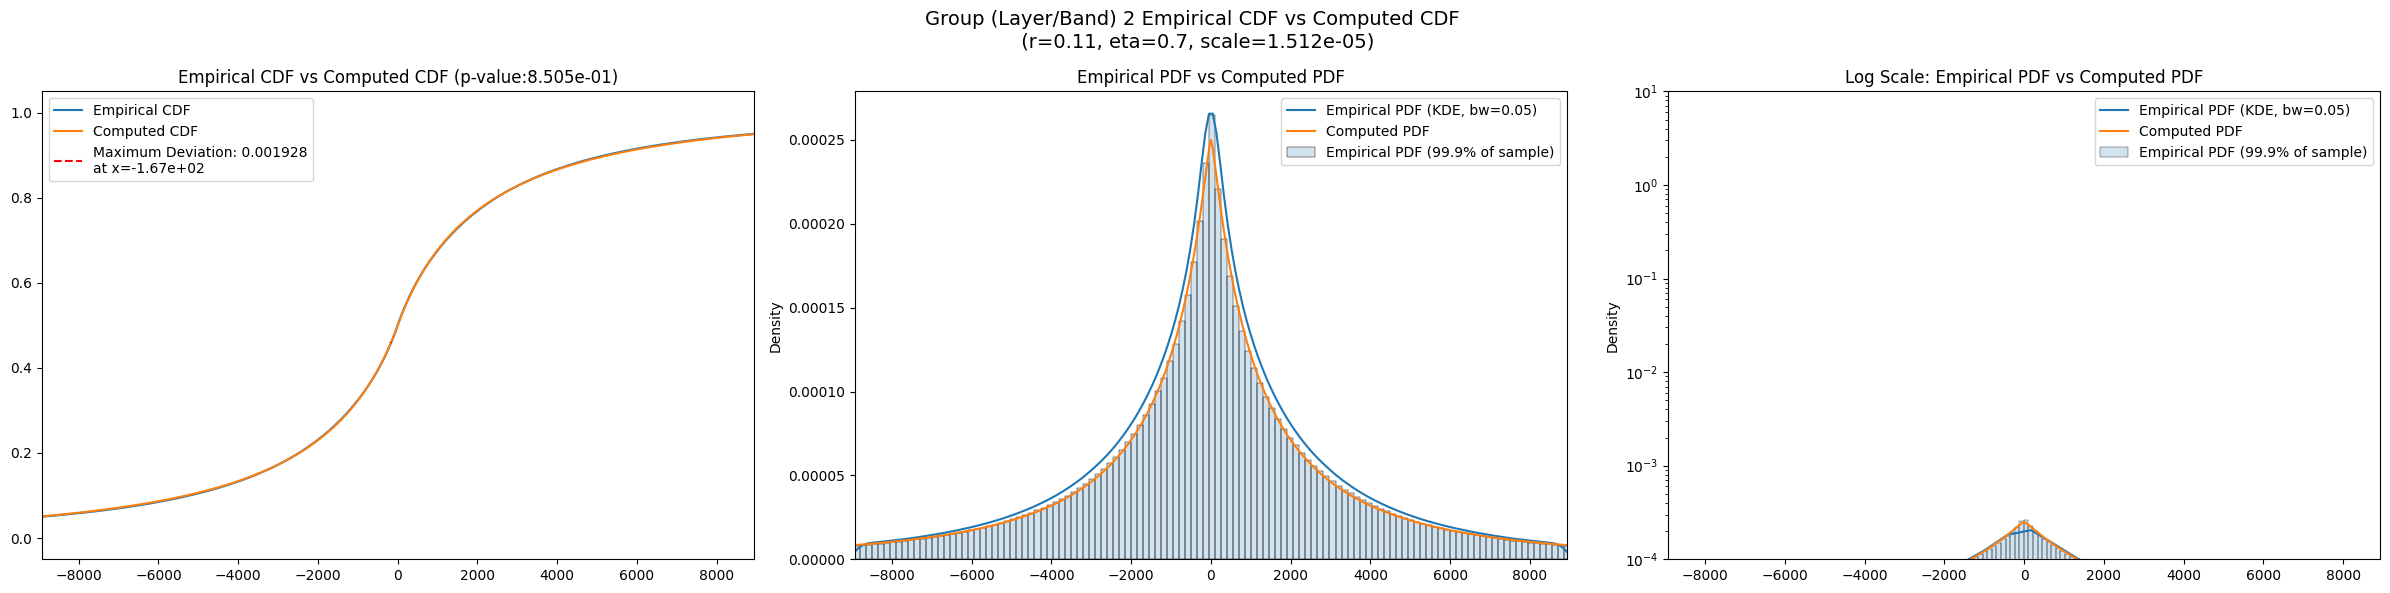

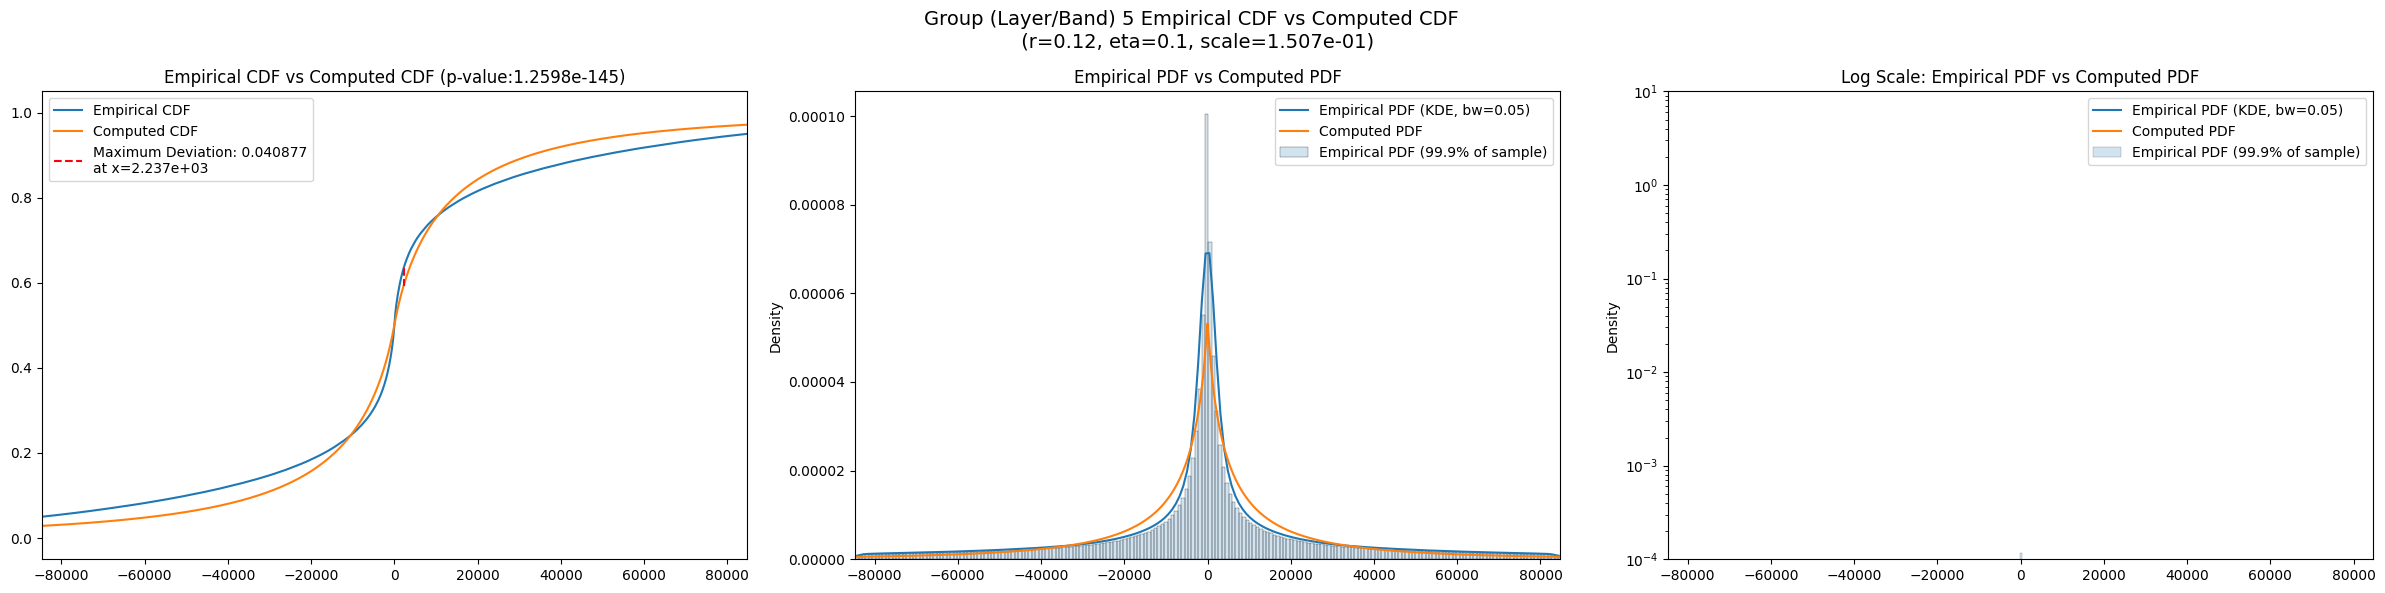

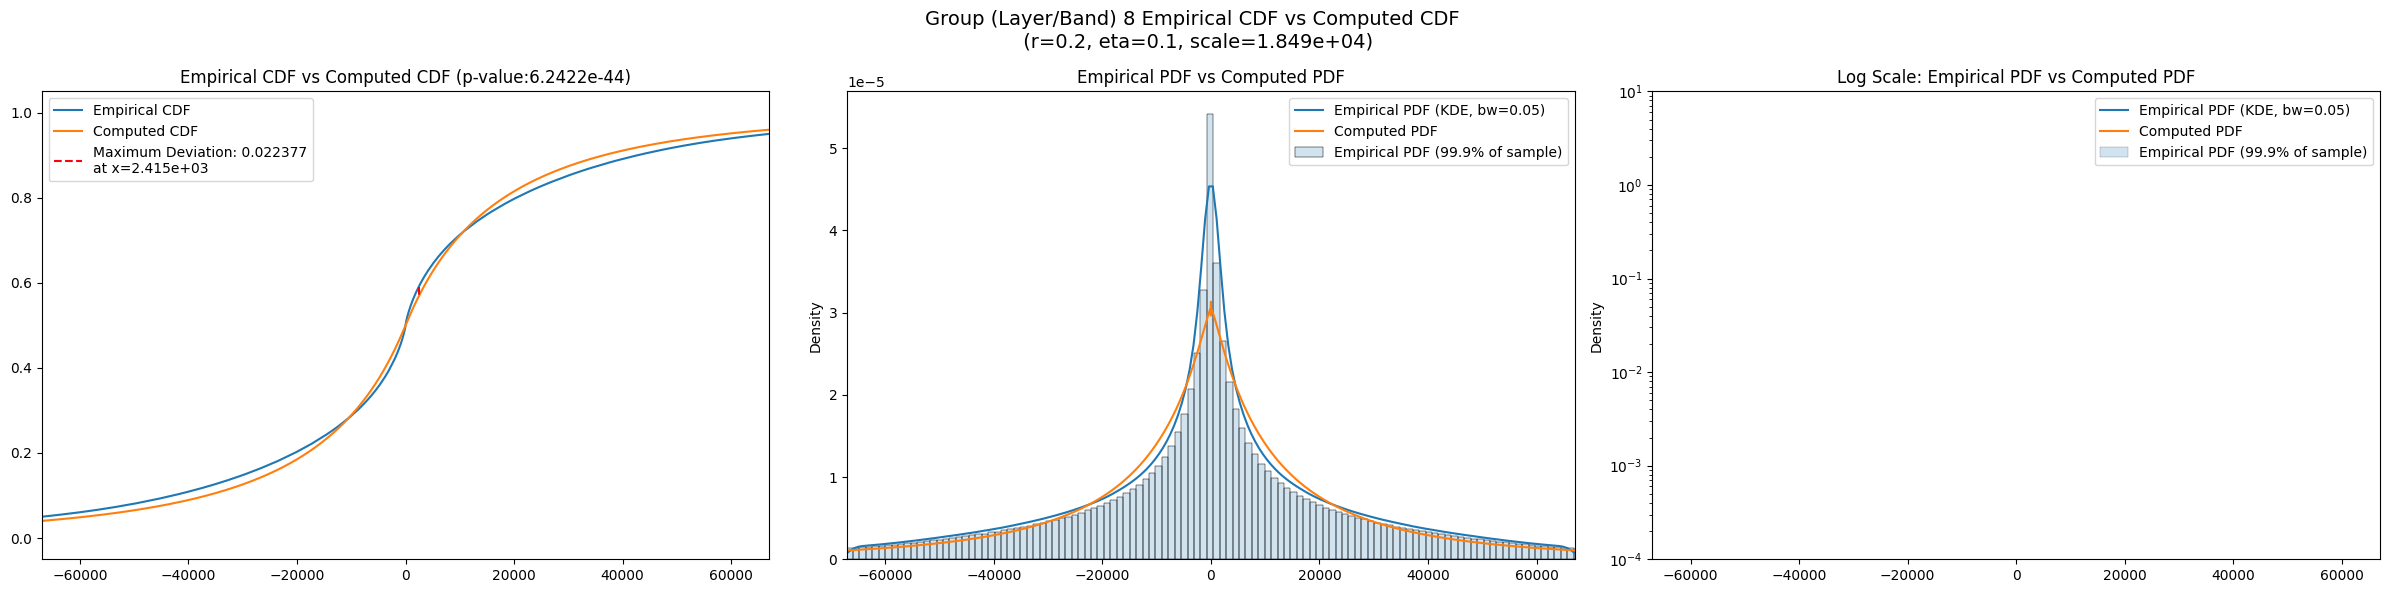

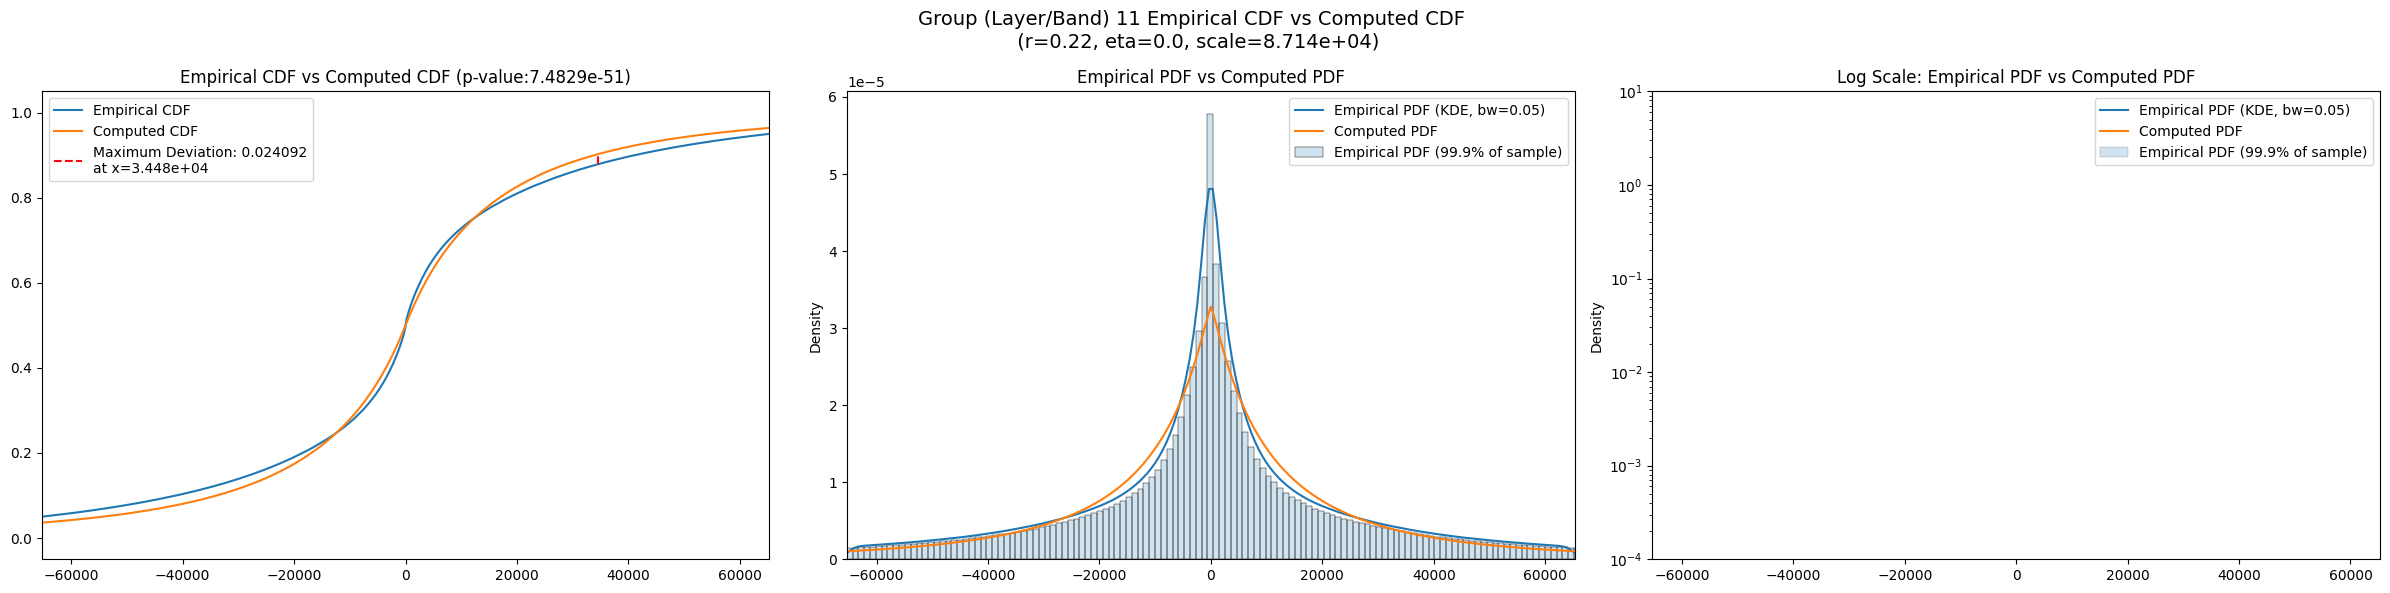

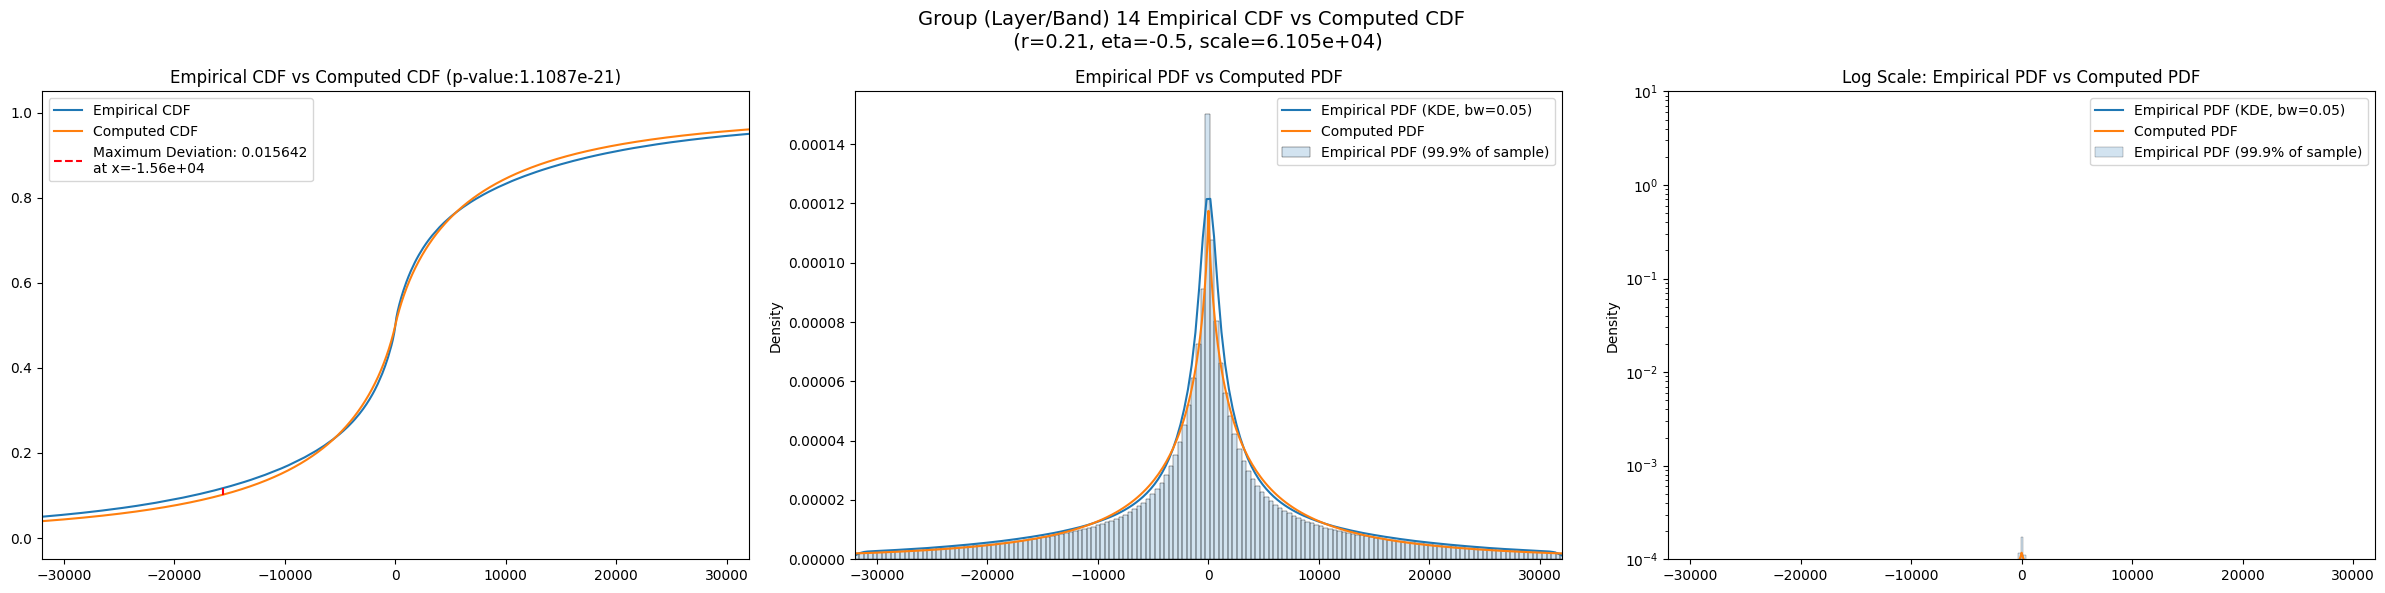

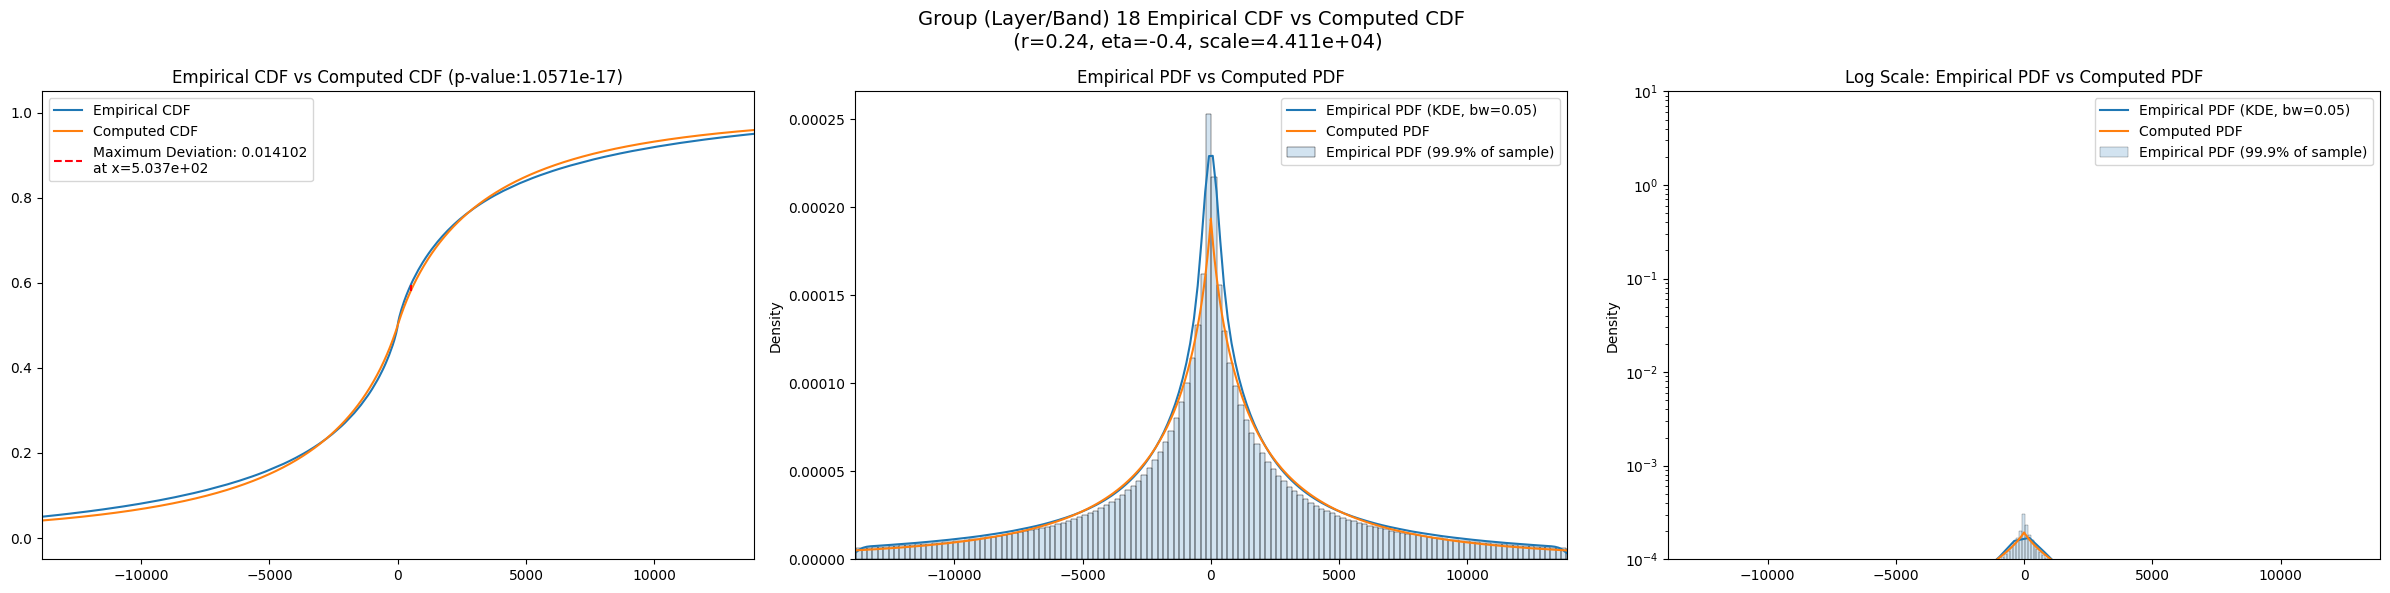

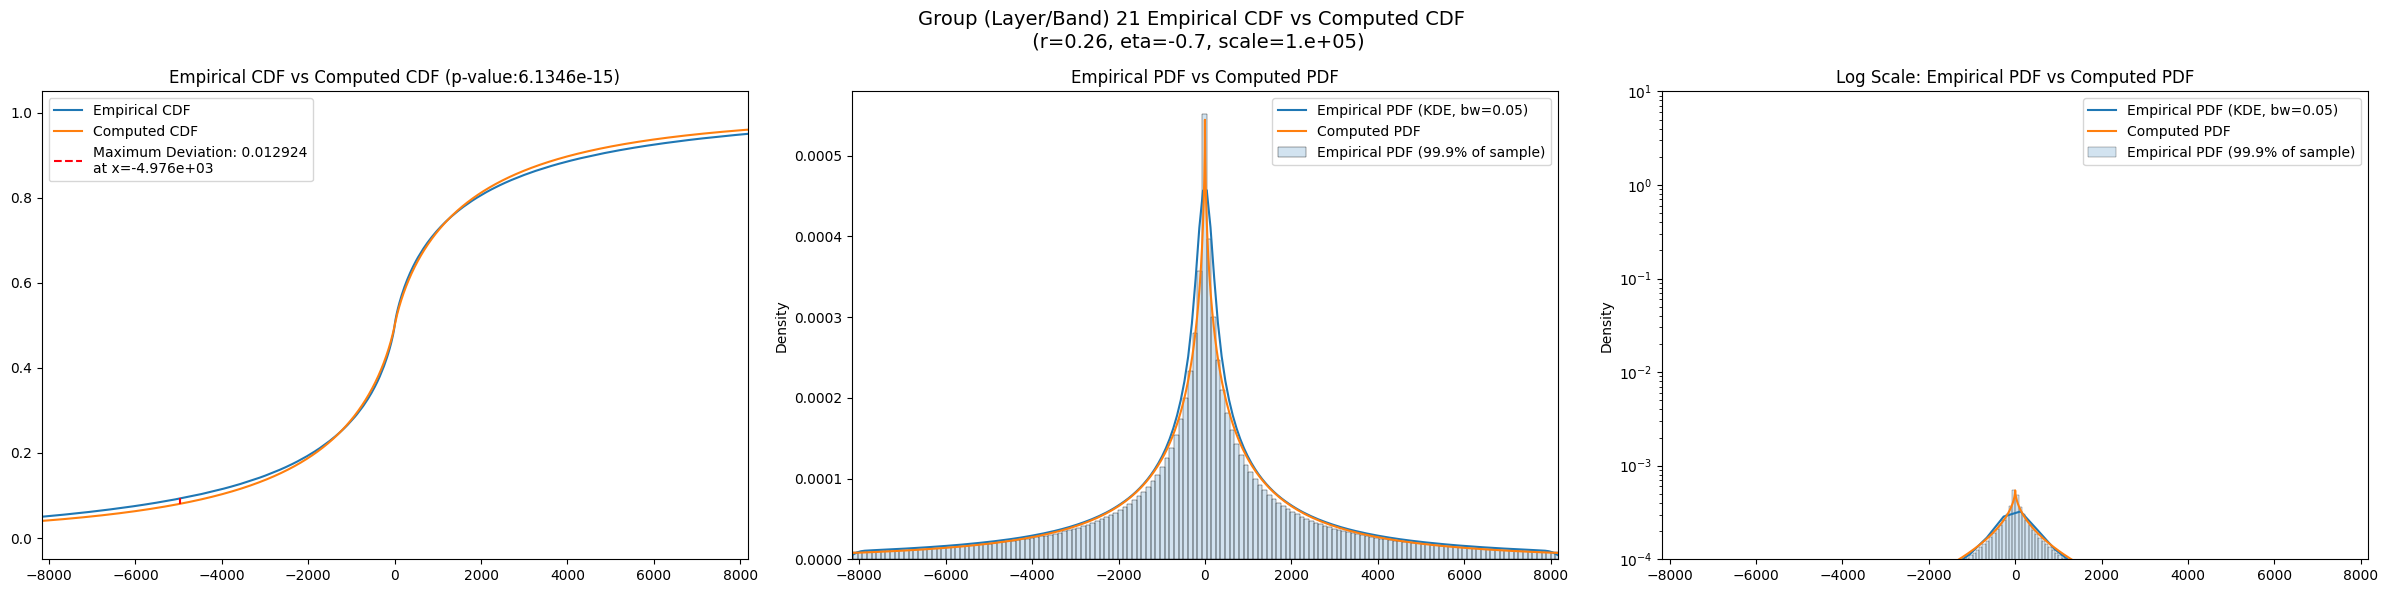

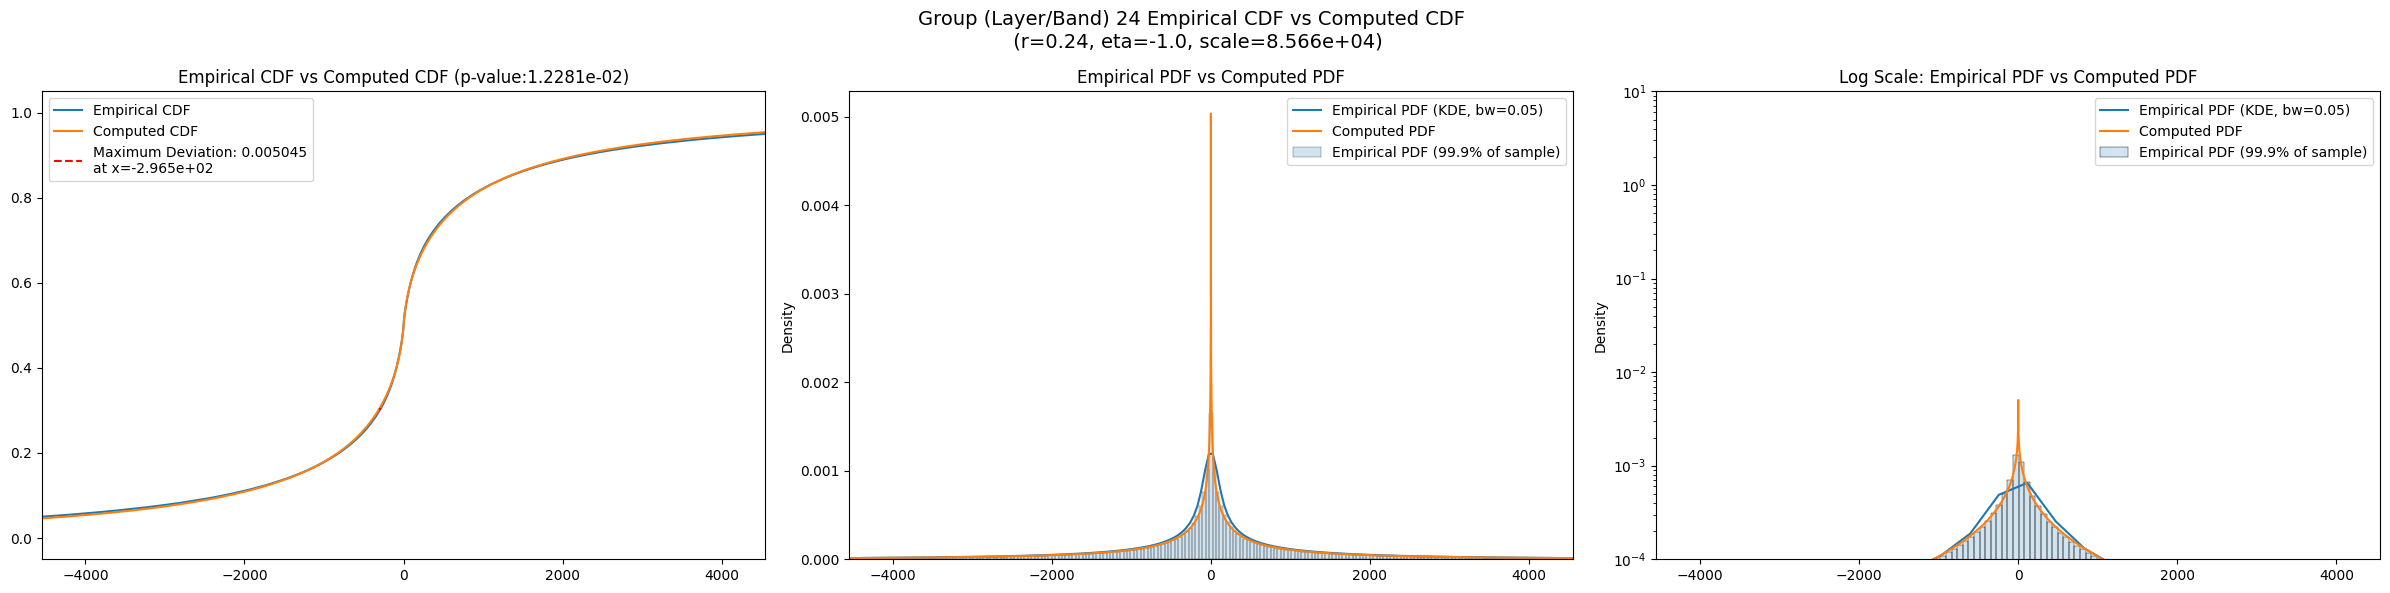

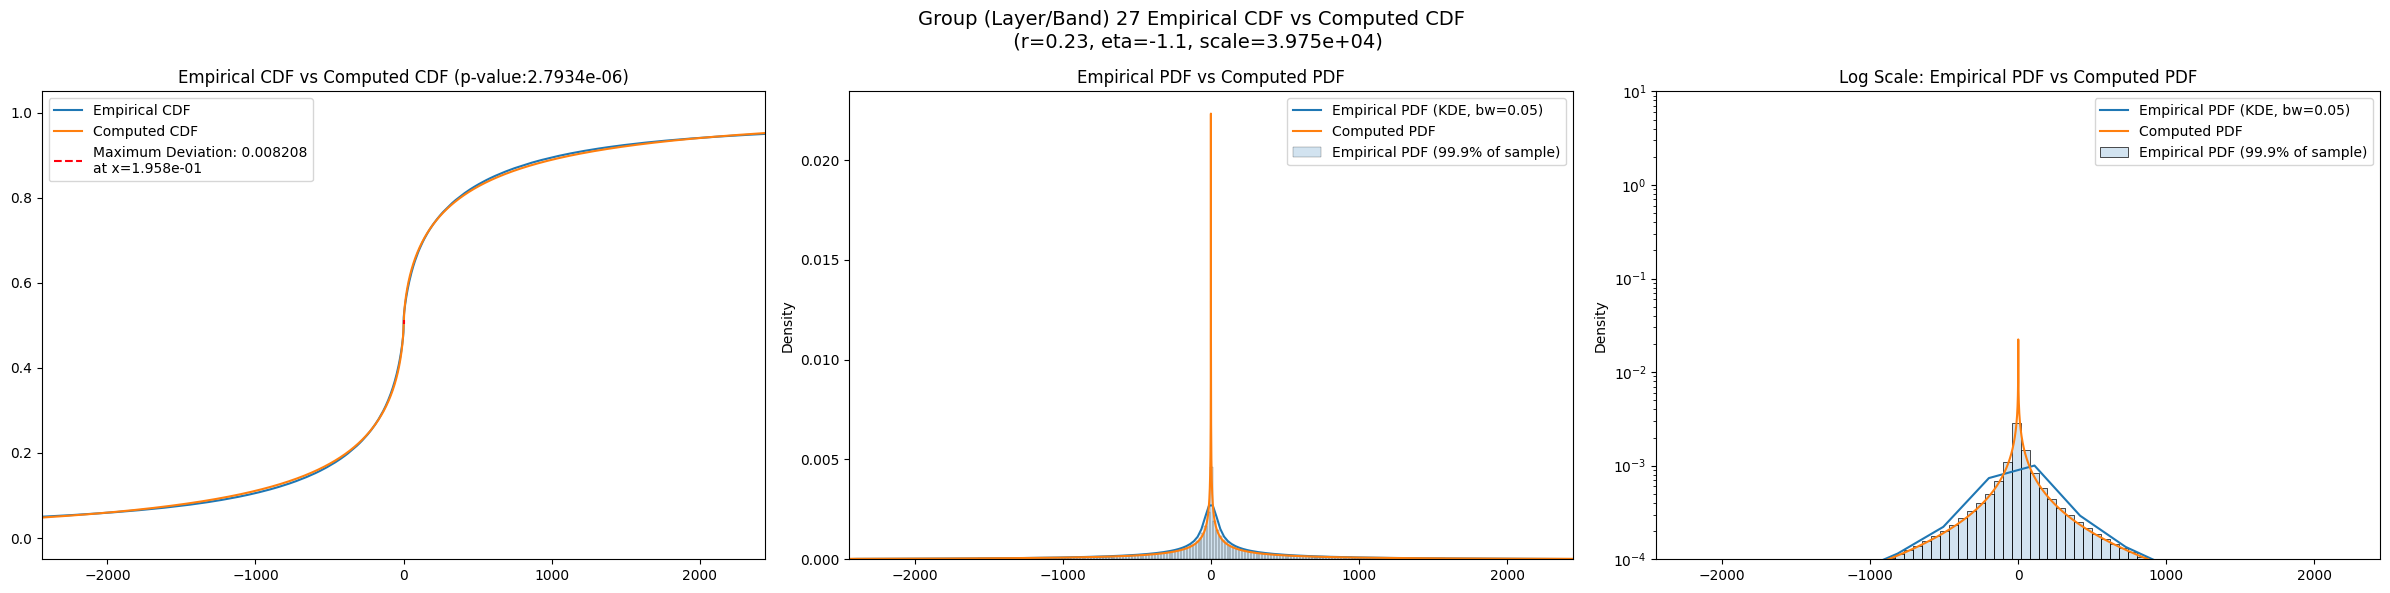

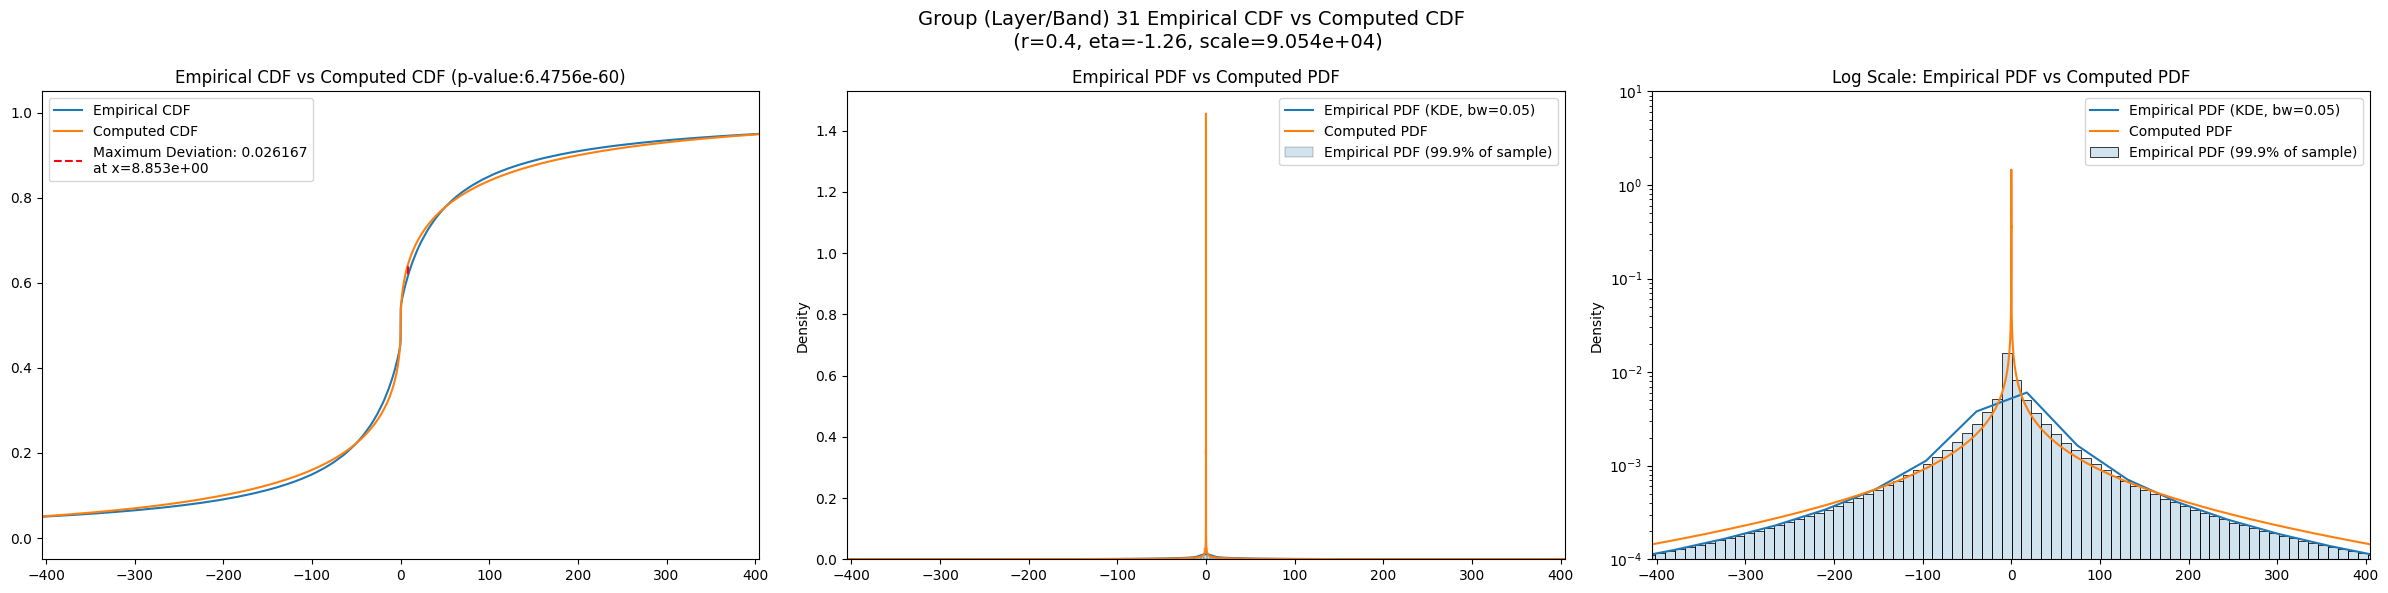

In [16]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [17]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [18]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
band                                                                    
2     5.139321e+07  4.463775e+07  6.096572e+07  34.034298   15.248034   
5     2.524177e+09  2.353391e+09  2.699740e+09   5.179779    4.626152   
8     1.757398e+09  1.641078e+09  1.877120e+09   4.847562    4.286242   
11    1.457189e+09  1.371756e+09  1.544339e+09   3.334230    2.998650   
14    4.547888e+08  4.189689e+08  4.917462e+08   7.730319    6.900269   
18    7.997943e+07  7.346398e+07  8.697122e+07   8.767644    6.914291   
21    2.985251e+07  2.706179e+07  3.292391e+07  12.333047    8.880222   
24    1.525364e+07  1.320449e+07  1.753561e+07  28.565693   21.727388   
27    1.007582e+07  8.521706e+06  1.176972e+07  37.237705   31.112600   
31    2.894142e+05  2.358549e+05  3.573860e+05  63.037277   39.385593   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2     117.524994     58064760.0             0.003482        0.1          1.1   
5       5.774006     58064760.0             0.042781        0.1          0.4   
8       5.420815     58064760.0             0.022377        0.2          0.1   
11      3.684760     58064760.0             0.025533        0.2          0.2   
14      8.605524     58064760.0             0.017737        0.2         -0.4   
18     11.307163     58064760.0             0.016546        0.2         -0.2   
21     17.917091     58064760.0             0.014891        0.2         -0.4   
24     36.901050     58064760.0             0.007226        0.2         -0.9   
27     44.299973     58064760.0             0.010080        0.2         -1.0   
31    147.871980     58064760.0             0.030406        0.3         -1.2   

      ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
band  ...                                                               
2     ...       3244.8800              0.054750                   0.0   
5     ...      19853.3000              0.099297                   0.0   
8     ...      24200.6000              0.062646                   0.0   
11    ...      22375.5000              0.067971                   0.0   
14    ...       9347.0700              0.075429                   0.0   
18    ...       4645.7300              0.066341                   0.0   
21    ...       2436.7500              0.072647                   0.0   
24    ...       1028.6800              0.086682                   0.0   
27    ...        471.9200              0.089008                   0.0   
31    ...         81.4933              0.085356                   0.0   

      param_laplace  kstest_stat_laplace  kstest_pval_laplace     param_t  \
band                                                                        
2         2860.1300             0.028447                  0.0   2230.3000   
5        16887.9000             0.075141                  0.0  13025.6000   
8        20658.3000             0.037511                  0.0  16678.1000   
11       19275.3000             0.041587                  0.0  15401.2000   
14        8074.7400             0.049283                  0.0   6347.2600   
18        4020.7100             0.039869                  0.0   3167.5900   
21        2110.6200             0.046798                  0.0   1643.5800   
24         890.9220             0.062062                  0.0    681.7010   
27         408.4740             0.065278                  0.0    308.9670   
31          70.6225             0.062432                  0.0     52.5638   

      kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
band                                                      
2          0.028203            0.0         6.849005e-188  
5          0.076034            0.0          0.000000e+00  
8          0.041984            0.0          0.000000e+00  
11         0.044731            0.0          0.000000e+00  
14         0.0508

## Results

In [19]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [20]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
band                                                                   
2                0.003482                 0.000178          0.001928   
5                0.042781                 0.000178          0.040877   
8                0.022377                 0.000178          0.022377   
11               0.025533                 0.000178          0.024092   
14               0.017737                 0.000178          0.015642   
18               0.016546                 0.000178          0.014102   
21               0.014891                 0.000178          0.012924   
24               0.007226                 0.000178          0.005045   
27               0.010080                 0.000178          0.008230   
31               0.030406                 0.000178          0.026972   

      kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
band                                                            
2                 0.054750             0.028447       0.028203  
5                 0.099297             0.075141       0.076034  
8                 0.062646             0.037511       0.041984  
11                0.067971             0.041587       0.044731  
14                0.075429             0.049283       0.050860  
18                0.066341             0.039869       0.041733  
21                0.072647             0.046798       0.047669  
24                0.086682             0.062062       0.061740  
27                0.089008             0.065278       0.064593  
31                0.085356             0.062432       0.061573

In [21]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta     best_scale  \
band                                                                          
2           5.139321e+07          0.001928    0.11      0.70       0.000015   
5           2.486232e+09          0.040877    0.12      0.10       0.150714   
8           1.757398e+09          0.022377    0.20      0.10   18491.136700   
11          1.457189e+09          0.024092    0.22      0.00   87139.533300   
14          4.547888e+08          0.015642    0.21     -0.50   61052.663455   
18          7.997943e+07          0.014102    0.24     -0.40   44110.908381   
21          2.985251e+07          0.012924    0.26     -0.70  100000.000000   
24          1.525364e+07          0.005045    0.24     -1.00   85661.460399   
27          6.040110e+06          0.008230    0.23     -1.10   39749.610368   
31          1.336049e+05          0.026972    0.40     -1.26   90535.826175   

      best_exclude_cutoff  
band                       
2                     0.0  
5                    25.0  
8                     0.0  
11                    0.0  
14                    0.0  
18                    0.0  
21                    0.0  
24                    0.0  
27                  300.0  
31                  400.0